# Starbucks and MTA Data

## Problem Statement:
Starbucks is a premier international coffee franchise with over 30,000 locations throughout the world. With New York City being one of the top cities to consume coffee, in all of the United States, Starbucks has imprinted its mark throughout the city, opening up more than 400 stores throughout the 5 boroughs, with 240 being specifically in Manhattan. 

The Metropolitan Transportation Authority (MTA) has become a very viable and popular means of transportation for people in New York City, seamlessly aiding people in getting to various part of the city that may be too far to walk or too expensive to take a taxi/uber to get too. With this means of transportation, thousands of people go through these arrays of turnstiles which leads to greater foot traffic in these general areas at certain times which would make it prime real estate to open up a Starbucks store. With looking at this turnstile data that the MTA provided, can we identify trends happening around certain subway stations that can possibly lead to expansion opportunities as well as mitigate risk with certain stores that aren’t becoming as popular.

With our seach, we will want to be focusing in on the E line to evaluate the best oppertunity. The E line was choosen as not only does it cover major parts of manhattan, it also extends throughout queens with the final stop being in Jamcia which is where many people come and transfer to take the airtrain to JFK Airport. Is there an oppertunity around a certain subway station 

We will assess our data with a time series analysis, using historical data of these stations and turnstiles to predict future foot traffic in each of the various locations. We will use the Seasonal Auto Regression Integrated Moving Average Exonginous (SARIMAX) model to evaluate and use regression, specifically Root Mean Squared Error (RMSE), to score our models. 



![](800px-MTA_New_York_City_Subway_logo.svg.png)
![](Starbucks_Corporation_Logo_2011.svg.png)


## Executive Summary

<img src = "euclidian.jpg" width ='400px'>

## Table of Contents

- [1.4 Acquiring and Preprocessing Data](#Acquiring-and-Preprocessing-Data)
- [1.5 Data Dictionary](#Data-Dictionary)
- [1.6 Loading Libraries](#Loading-Libraries)
- [1.7 Loading Data](#Loading-Data)
- [1.8 EDA](#EDA)
- [1.9 Featured Engineering](#CFeatured-Engineering)
- [1.10 Model Preparation](#Model-Preparation)
- [1.11 Modeling](#Modeling)
- [1.12 Model Selection](#Model-Selection)
- [1.13 Model Evaluation](#Model-Evaluation)
- [1.14 Conclusion](#Conclusion)
- [1.15 Conclusion](#Conclusion)

## Acquiring and Preprocessing Data

__Talk about other notebook__

## Data Dictionary

|Feature|Type|Description|
|---|---|---|
|**C/A**|*object*|Control Area name/Booth name. This is the internal identification of a booth at a given station.|
|**UNIT**|*object*|Remote unit ID of station|
|**SCP**|*object*|Subunit/Channel/position represents a specific address for a given device|
|**Station**|*object*|Name assigned to the subway station by operations planning.| 
|**Line Name**|*object*|Train lines stopping at this location. Can contain up to 20 single character identifier. When more than one train line appears, it is usually intercepting train lines, in major stations where the passenger can transfer between any one of the lines.|
|**Division**|*object*|Each section of the system is assigned a unique line name, usually paired with its original operating company or division (Brooklyn– Manhattan Transit Corporation (BMT), Interborough Rapid Transit Company (IRT), and Independent Subway System (IND).|
|**month**|*object*|Month of year that individual turnstile data is related too.|
|**day**|*object*|Day of Week that individual turnstile data is related too.|
|**Station_Latitude**|*float*|Latitude coordinates of station |
|**Station_Longitude**|*float*|Longitude coordinates of station|
|**first_closest**|*float*|Distance of the first closest store|
|**first_closest_store**|*object*|Name of the first closest store|
|**second_closest**|*float*|Distance of the second closest store|
|**second_closest_store**|*object*|Name of the second closest store|
|**third_closest**|*float*|Distance of the third closest store|
|**third_closest_store**|*object*|Name of the third closest store|
|**Entries**|*int*|number of entries at that turnstile|
|**Exits**|*int*|number of exits at that turnstile|
|**total_turns**|*int*|combined entries and exits at that turnstile|
|**avg_distance**|*float*|The first, second, and third closest numbers multipled together|


## Loading Libraries 

In [16]:
#cleaning libraries
import requests
import pandas as pd
import numpy as np
from PIL import Image
from difflib import get_close_matches 
#evaluation
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, train_test_split
import folium
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

#graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Loading Data

Load the stations CSV we created in the Starbucks Cleaning notebook

In [17]:
stations = pd.read_csv('Data/stations.csv')
stations.head()

,Station_Latitude,Station_Longitude,Route_8,Route_9,Route_10,Route_11,ADA,Free_Crossover,Latitude,Longitude,station,first_closest,first_closest_store,second_closest,second_closest_store,third_closest,third_closest_store
0,40.740893,-74.001690,NaN,NaN,NaN,NaN,1.0,1.0,40.740612,-74.001896,14th St,0.001861,8th Ave just south of 14th St,0.002499,19th & 8th,0.003523,Greenwich Ave at Bank St
1,40.745906,-73.998041,NaN,NaN,NaN,NaN,0.0,1.0,40.745990,-73.997927,23rd St,0.003181,24th & 7th,0.003717,19th & 8th,0.003729,23rd & 1st
2,40.747846,-73.946000,NaN,NaN,NaN,NaN,0.0,1.0,40.747807,-73.945829,23rd St-Ely Av,0.013156,Roosevelt Island,0.021601,69th & First,0.023777,75th & First
3,40.752287,-73.993391,NaN,NaN,NaN,NaN,1.0,1.0,40.752218,-64.744260,34th St,0.001281,"Penn Station by A,C,E",0.001281,One Penn Plaza,0.003779,32nd btwn 6th & 7th
4,40.757308,-73.989735,1.0,2.0,3.0,7.0,1.0,1.0,40.757358,-73.989816,42nd St,0.000612,42nd & 8th,0.000680,Union Square East,0.001043,43rd & 8th


Load in the 2017 Turnstile data that we were able to obtain from the MTA website

In [18]:
df_2017 = pd.read_csv('Data/turnstile-usage-data-2017.csv')


In [19]:
df_2017.head()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-22T00:00:00.000,23:00:00,REGULAR,6455787,2184977
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-22T00:00:00.000,19:00:00,REGULAR,6455505,2184926
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-22T00:00:00.000,15:00:00,REGULAR,6454819,2184867
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-22T00:00:00.000,11:00:00,REGULAR,6454437,2184773
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-12-22T00:00:00.000,07:00:00,REGULAR,6454285,2184501


## Preliminary EDA

Within the Preliminary EDA, we will setup one Dataframe that will be used to start feature engineering and setting up various graphs to look at

In [20]:
df_2017.describe()

,Entries,Exits
count,8.880000e+06,8.880000e+06
mean,3.235230e+07,2.559780e+07
std,1.900627e+08,1.670014e+08
min,0.000000e+00,0.000000e+00
25%,7.124620e+05,3.555350e+05
50%,2.896117e+06,1.623704e+06
75%,8.249612e+06,4.641913e+06
max,2.032571e+09,2.140537e+09


When looking at the decribe statistics, the maximum do look high as these are cumulative totals. We will adjust to make them daily totals later on. 

In [21]:
df_2017.isnull().sum()

C/A                                                           0
Unit                                                          0
SCP                                                           0
Station                                                       0
Line Name                                                     0
Division                                                      0
Date                                                          0
Time                                                          0
Description                                                   0
Entries                                                       0
Exits                                                         0
dtype: int64

Noted that there are not null values within the data set

In [22]:
len(df_2017['Line Name'])

8880000

In [23]:
df_2017['Line Name'].unique()

array(['NQR456W', 'NQRW', 'ACENQRS1237W', 'BDFMNQRW', 'NRW', 'LNQR456W',
       'JNQRZ6W', 'RNW', 'R1W', 'FJMZ', 'JZ', 'JZ456', 'ACJZ2345', 'BQ',
       'S', 'S2345', 'BQS', 'Q', 'R2345', 'R', 'BDNQR', 'BDNQR2345',
       'DFGMNR', 'DNR', 'N', 'ND', 'D', 'DFNQ', 'ACEL', 'FLM123', 'L',
       'LG', 'LM', 'JMZ', 'JM', 'J', 'A', 'E', 'M', 'AC1', 'C', 'ABCD',
       'BC', 'ACBD', 'ABCD1', 'ACENGRS1237W', 'ACE', 'CE', 'ABCDEFM',
       'ACE23', '2345ACJZ', 'AC', 'ACF', 'ACG', 'ACS', 'ACJLZ', 'AS',
       'BD', 'BD4', 'BDE', 'EM', 'EM6', 'EMG', 'EMR', 'MR', 'EFMR7',
       'EFMR', 'EF', 'F', 'G', 'GL', 'BDFM', 'BDFM7', 'FM', 'BDFQ6', 'FG',
       '1', 1, '1RW', '23', '123', '123FLM', 123, '1237ACENQRSW', '1ABCD',
       45], dtype=object)

When we tried to filter out the data frame and create a new one with the E line only, we had troubles as there are some values within the line column that needed to be changed due to them being integers. since trying to string the column didnt work, we simply filtered them out of the dataframe.

In [24]:
df_2017 = df_2017[(df_2017['Line Name']!= 1) & (df_2017['Line Name']!= 123) & (df_2017['Line Name']!= 45)]


In [25]:
df_2017.loc[df_2017["Station"] == "50 ST","Line Name"]= df_2017.loc[df_2017["Station"] == "50 ST","Line Name"].replace('D', 'E')

As we pulled out values and plotted them on a map, I noticed that there was a missing station due to my subject knowledge of the E line and that the 50th station was not there. When investigating the cause, I saw that the data set had the 'D' line in rather than teh 'E'. With a simple replace, we were able to resolve this and ensured we had the correct stations for out data. When at the real line on https://moovitapp.com/index/en/public_transit-line-E-NYCNJ-121-855111-513452-0 , there were also late night stations on the E line in Queens that werent in our data. Since these are stations that arent open all day, we deemed that they would not be necessary for our analysis and left them out.

In [26]:
df_e = df_2017.loc[df_2017['Line Name'].str.contains('E'),:]

Created a dataframe with just the stations that contain the E line

In [27]:
df_e['Station'].sort_values().unique()

array(['14 ST', '23 ST', '34 ST-PENN STA', '42 ST-PORT AUTH',
       '5 AV/53 ST', '50 ST', '7 AV', '75 AV', '8 AV', 'BRIARWOOD',
       'CANAL ST', 'CHAMBERS ST', 'COURT SQ', 'COURT SQ-23 ST',
       'FOREST HILLS 71', 'JFK JAMAICA CT1', 'JKSN HT-ROOSVLT',
       'KEW GARDENS', 'LEXINGTON AV/53', 'QUEENS PLAZA', 'SPRING ST',
       'TIMES SQ-42 ST', 'W 4 ST-WASH SQ', 'WORLD TRADE CTR'],
      dtype=object)

In [28]:
len(df_e)

890571

In [29]:
del(df_2017)

well delete the old dataframe as it is over 8 million rows and takes up a lot of space

In [30]:
def date_manip(df):
    new_date = [i.split('T')[0] for i in df['Date']]
    df['Date'] = new_date
    df['date_time'] = pd.to_datetime(df.Date + ' ' + df.Time)
    return df.head()

Created a function that will manipulate the date so that it is in Date and Time for us to set as our index on when we complete the cleaning. 

In [31]:
date_manip(df_e)

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits,date_time
118432,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,23:00:00,REGULAR,7357995,8791810,2017-12-22 23:00:00
118433,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,19:00:00,REGULAR,7357446,8791371,2017-12-22 19:00:00
118434,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,15:00:00,REGULAR,7356450,8790311,2017-12-22 15:00:00
118435,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,11:00:00,REGULAR,7355728,8789251,2017-12-22 11:00:00
118436,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,07:00:00,REGULAR,7355235,8787730,2017-12-22 07:00:00


We will create several functions for us to run to extract exact month and day of the week which we will use later on to examine the data

In [32]:
def doy(day):
    return day.day_name()

In [33]:
def moy(month):
    return month.month_name()

In [34]:
def map_day_to_df(df):
    df['day'] = df['date_time'].map(doy)
    return df.head()

In [35]:
def map_month_to_df(df):
    df['month'] = df['date_time'].map(moy)
    return df.head()

In [36]:
map_day_to_df(df_e)

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits,date_time,day
118432,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,23:00:00,REGULAR,7357995,8791810,2017-12-22 23:00:00,Friday
118433,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,19:00:00,REGULAR,7357446,8791371,2017-12-22 19:00:00,Friday
118434,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,15:00:00,REGULAR,7356450,8790311,2017-12-22 15:00:00,Friday
118435,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,11:00:00,REGULAR,7355728,8789251,2017-12-22 11:00:00,Friday
118436,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,07:00:00,REGULAR,7355235,8787730,2017-12-22 07:00:00,Friday


Extracted the day of the week

In [37]:
map_month_to_df(df_e)

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits,date_time,day,month
118432,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,23:00:00,REGULAR,7357995,8791810,2017-12-22 23:00:00,Friday,December
118433,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,19:00:00,REGULAR,7357446,8791371,2017-12-22 19:00:00,Friday,December
118434,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,15:00:00,REGULAR,7356450,8790311,2017-12-22 15:00:00,Friday,December
118435,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,11:00:00,REGULAR,7355728,8789251,2017-12-22 11:00:00,Friday,December
118436,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,07:00:00,REGULAR,7355235,8787730,2017-12-22 07:00:00,Friday,December


Extracted the months

The next step we had to take was to find a way to merge now our two station data sets together, one with the station locations and closest starbucks and the other with the turnstile info. For that, we needed to get the station names to match up together. We had to make a conversion dictionary that would then be mapped to our station location dataframe as a means of merging them together. With the help of the get_close_matches fucntion. this expediated the process for us to search within the unique values of the turnstile dataframe to match the closest named station which did work at about a 75% clip. The other 25% where it wasnt able to indentify, we had to mannually go through the list to figure out the matching station.

In [38]:
stations['station'] = stations['station'].str.upper()

In [39]:
stations.head()

,Station_Latitude,Station_Longitude,Route_8,Route_9,Route_10,Route_11,ADA,Free_Crossover,Latitude,Longitude,station,first_closest,first_closest_store,second_closest,second_closest_store,third_closest,third_closest_store
0,40.740893,-74.001690,NaN,NaN,NaN,NaN,1.0,1.0,40.740612,-74.001896,14TH ST,0.001861,8th Ave just south of 14th St,0.002499,19th & 8th,0.003523,Greenwich Ave at Bank St
1,40.745906,-73.998041,NaN,NaN,NaN,NaN,0.0,1.0,40.745990,-73.997927,23RD ST,0.003181,24th & 7th,0.003717,19th & 8th,0.003729,23rd & 1st
2,40.747846,-73.946000,NaN,NaN,NaN,NaN,0.0,1.0,40.747807,-73.945829,23RD ST-ELY AV,0.013156,Roosevelt Island,0.021601,69th & First,0.023777,75th & First
3,40.752287,-73.993391,NaN,NaN,NaN,NaN,1.0,1.0,40.752218,-64.744260,34TH ST,0.001281,"Penn Station by A,C,E",0.001281,One Penn Plaza,0.003779,32nd btwn 6th & 7th
4,40.757308,-73.989735,1.0,2.0,3.0,7.0,1.0,1.0,40.757358,-73.989816,42ND ST,0.000612,42nd & 8th,0.000680,Union Square East,0.001043,43rd & 8th


In [40]:
from difflib import SequenceMatcher,get_close_matches

SequenceMatcher(None,'Prospect Park' , 'PROSPECT PARK').ratio()

0.23076923076923078

In [41]:
stations['station'].sort_values().unique()

array(['14TH ST', '23RD ST', '23RD ST-ELY AV', '34TH ST', '42ND ST',
       '45 RD-COURT HOUSE SQ', '50TH ST', '51ST ST', '5TH AV-53RD ST',
       '75TH AV', '7TH AV', '8TH AV', 'BROADWAY-74TH ST', 'CANAL ST',
       'CHAMBERS ST', 'FOREST HILLS-71ST AV',
       'JACKSON HEIGHTS-ROOSEVELT AVE', 'JAMAICA-VAN WYCK',
       'KEW GARDENS-UNION TURNPIKE', 'LEXINGTON AV-53RD ST', 'PARK PLACE',
       'PARSONS BLVD-ARCHER AV - JAMAICA CENTER', 'QUEENS PLAZA',
       'SPRING ST', 'SUTPHIN BLVD-ARCHER AV - JFK', 'TIMES SQUARE',
       'TIMES SQUARE-42ND ST', 'WEST 4TH ST', 'WORLD TRADE CENTER'],
      dtype=object)

In [42]:
df_e['Station'].sort_values().unique()

array(['14 ST', '23 ST', '34 ST-PENN STA', '42 ST-PORT AUTH',
       '5 AV/53 ST', '50 ST', '7 AV', '75 AV', '8 AV', 'BRIARWOOD',
       'CANAL ST', 'CHAMBERS ST', 'COURT SQ', 'COURT SQ-23 ST',
       'FOREST HILLS 71', 'JFK JAMAICA CT1', 'JKSN HT-ROOSVLT',
       'KEW GARDENS', 'LEXINGTON AV/53', 'QUEENS PLAZA', 'SPRING ST',
       'TIMES SQ-42 ST', 'W 4 ST-WASH SQ', 'WORLD TRADE CTR'],
      dtype=object)

In [43]:
get_close_matches('TIMES SQUARE-42ND ST' ,stations['station'].unique(), n=5)

['TIMES SQUARE-42ND ST', 'TIMES SQUARE']

This above is an example of how the get_close_matches function worked. This was run with all the unique values we had in the df_e dataframe to match the values in the df dataframe.

In [44]:
conv_station_dict = {
    'TIMES SQUARE-42ND ST': 'TIMES SQ-42 ST', 
    '8TH AV': '8 AV', 
    'SUTPHIN BLVD-ARCHER AV - JFK':'JFK JAMAICA CT1', 
    '42ND ST': '42 ST-PORT AUTH',
    '34TH ST': '34 ST-PENN STA', 
    '23RD ST':'23 ST', 
    '14TH ST':'14 ST', 
    'WEST 4TH ST': 'W 4 ST-WASH SQ', 
    'SPRING ST': 'SPRING ST',
    'CANAL ST': 'CANAL ST', 
    'CHAMBERS ST': 'CHAMBERS ST', 
    'WORLD TRADE CENTER': 'WORLD TRADE CTR', 
    '7TH AV': '7 AV', 
    '5TH AV-53RD ST': '5 AV/53 ST',
    'LEXINGTON AV-53RD ST': 'LEXINGTON AV/53', 
    '45 RD-COURT HOUSE SQ': 'COURT SQ-23 ST', 
    'QUEENS PLAZA': 'QUEENS PLAZA',
    'JACKSON HEIGHTS-ROOSEVELT AVE': 'JKSN HT-ROOSVLT', 
    'FOREST HILLS-71ST AV': 'FOREST HILLS 71', 
    '75TH AV': '75 AV', 
    'KEW GARDENS-UNION TURNPIKE':'KEW GARDENS',
    'JAMAICA-VAN WYCK': 'BRIARWOOD', 
    '50TH ST' : '50 ST'
}

stations['station'] = stations['station'].map(conv_station_dict)

In [45]:
stations['station'].unique()

array(['14 ST', '23 ST', nan, '34 ST-PENN STA', '42 ST-PORT AUTH',
       'COURT SQ-23 ST', '50 ST', '5 AV/53 ST', '75 AV', '7 AV', '8 AV',
       'CANAL ST', 'CHAMBERS ST', 'FOREST HILLS 71', 'JKSN HT-ROOSVLT',
       'BRIARWOOD', 'KEW GARDENS', 'LEXINGTON AV/53', 'QUEENS PLAZA',
       'SPRING ST', 'JFK JAMAICA CT1', 'TIMES SQ-42 ST', 'W 4 ST-WASH SQ',
       'WORLD TRADE CTR'], dtype=object)

In [46]:
temp_stations = stations.dropna(axis=0, subset=['station'])

After now mapping the stations to map, we simply dropped all other stations that were not needed.

In [47]:
temp_stations.head()

,Station_Latitude,Station_Longitude,Route_8,Route_9,Route_10,Route_11,ADA,Free_Crossover,Latitude,Longitude,station,first_closest,first_closest_store,second_closest,second_closest_store,third_closest,third_closest_store
0,40.740893,-74.001690,NaN,NaN,NaN,NaN,1.0,1.0,40.740612,-74.001896,14 ST,0.001861,8th Ave just south of 14th St,0.002499,19th & 8th,0.003523,Greenwich Ave at Bank St
1,40.745906,-73.998041,NaN,NaN,NaN,NaN,0.0,1.0,40.745990,-73.997927,23 ST,0.003181,24th & 7th,0.003717,19th & 8th,0.003729,23rd & 1st
3,40.752287,-73.993391,NaN,NaN,NaN,NaN,1.0,1.0,40.752218,-64.744260,34 ST-PENN STA,0.001281,"Penn Station by A,C,E",0.001281,One Penn Plaza,0.003779,32nd btwn 6th & 7th
4,40.757308,-73.989735,1.0,2.0,3.0,7.0,1.0,1.0,40.757358,-73.989816,42 ST-PORT AUTH,0.000612,42nd & 8th,0.000680,Union Square East,0.001043,43rd & 8th
5,40.747023,-73.945264,NaN,NaN,NaN,NaN,0.0,1.0,40.746223,-73.945461,COURT SQ-23 ST,0.014239,Roosevelt Island,0.022691,69th & First,0.023533,35th Ave and 37th St


In [48]:
temp_stations = temp_stations[['station', 'Station_Latitude', 'Station_Longitude', 'first_closest', 'first_closest_store', 'second_closest', 'second_closest_store', 'third_closest', 'third_closest_store']]

We wanted to extract just the columns that we were going to use in our stations dataframe to merge onto the new dataframe

In [49]:
temp_stations.rename(columns = {'station': 'Station'}, inplace = True)

Before we merged, we wanted to make sure that the column names we were merging on were the same

In [50]:
df_merged =  pd.merge(left = df_e,
        right = temp_stations,
        how ='inner',
        on = 'Station')

We have now our merged dataframe that we will work with

In [51]:
df_merged.columns

Index(['C/A', 'Unit', 'SCP', 'Station', 'Line Name', 'Division', 'Date',
       'Time', 'Description', 'Entries',
       'Exits                                                     ',
       'date_time', 'day', 'month', 'Station_Latitude', 'Station_Longitude',
       'first_closest', 'first_closest_store', 'second_closest',
       'second_closest_store', 'third_closest', 'third_closest_store'],
      dtype='object')

When taking a look at the columns, we noticed that 'Exits' column needed to be corrected to remove the space

In [52]:
df_merged.rename(columns = {'Exits                                                     ': 'Exits'}, inplace = True)

In [53]:
df_merged = df_merged.set_index(['date_time'])

We now set our index to the new dataframe as the date


In [54]:
df_merged.sort_index(inplace = True, ascending = False)

In [55]:
df_merged.head()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,...,day,month,Station_Latitude,Station_Longitude,first_closest,first_closest_store,second_closest,second_closest_store,third_closest,third_closest_store
date_time,,,,,,,,,,,,,,,,,,,,,
2017-12-22 23:00:00,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-12-22,23:00:00,REGULAR,7357995,...,Friday,December,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th
2017-12-22 23:00:00,N092,R029,03-03-01,CHAMBERS ST,ACE23,IND,2017-12-22,23:00:00,REGULAR,51957,...,Friday,December,40.714111,-74.008585,0.000759,Church Street & Murray,0.001266,Chambers and West Broadway,0.001697,Broadway at Barclay Str
2017-12-22 23:00:00,N092,R029,03-00-05,CHAMBERS ST,ACE23,IND,2017-12-22,23:00:00,REGULAR,2344966,...,Friday,December,40.714111,-74.008585,0.000759,Church Street & Murray,0.001266,Chambers and West Broadway,0.001697,Broadway at Barclay Str
2017-12-22 23:00:00,R151,R033,00-00-07,TIMES SQ-42 ST,1237ACENQRSW,IRT,2017-12-22,23:00:00,REGULAR,1245589,...,Friday,December,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th
2017-12-22 23:00:00,N092,R029,03-00-04,CHAMBERS ST,ACE23,IND,2017-12-22,23:00:00,REGULAR,10378155,...,Friday,December,40.714111,-74.008585,0.000759,Church Street & Murray,0.001266,Chambers and West Broadway,0.001697,Broadway at Barclay Str


For some locations, Starbucks is open 24 hours a day. However, normal operations for Starbucks during the week are between 07:00 AM – 11:00 PM. Since most of Starbucks business comes in during the morning time as their primary source of business is coffee, we will filter out the hours to 06:00 AM - 12:00PM.


In [56]:
df_merged.between_time('06:00:00', '12:00:00')

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,...,day,month,Station_Latitude,Station_Longitude,first_closest,first_closest_store,second_closest,second_closest_store,third_closest,third_closest_store
date_time,,,,,,,,,,,,,,,,,,,,,
2017-12-22 12:00:00,N078,R175,01-00-01,14 ST,ACEL,IND,2017-12-22,12:00:00,REGULAR,557480,...,Friday,December,40.740893,-74.001690,0.001861,8th Ave just south of 14th St,0.002499,19th & 8th,0.003523,Greenwich Ave at Bank St
2017-12-22 12:00:00,N333B,R141,02-00-01,FOREST HILLS 71,EFMR,IND,2017-12-22,12:00:00,REGULAR,1449764,...,Friday,December,40.721691,-73.844521,0.001279,107-12 Continental Avenue,0.002948,7000 Austin Street,0.009394,Queens Blvd & 67th Rd
2017-12-22 12:00:00,N078,R175,01-00-01,14 ST,ACEL,IND,2017-12-22,12:00:00,REGULAR,557480,...,Friday,December,40.740893,-74.001690,0.001861,8th Ave just south of 14th St,0.002499,19th & 8th,0.003523,Greenwich Ave at Bank St
2017-12-22 12:00:00,N309A,R140,00-03-00,QUEENS PLAZA,EMR,IND,2017-12-22,12:00:00,REGULAR,97648,...,Friday,December,40.748973,-73.937243,0.015421,35th Ave and 37th St,0.017912,31-01 Broadway,0.018468,Roosevelt Island
2017-12-22 12:00:00,JFK03,R536,00-00-01,JFK JAMAICA CT1,E,IND,2017-12-22,12:00:00,REGULAR,110230,...,Friday,December,40.700486,-73.807969,0.003170,89th Ave & Sutphin Blvd.,0.027711,118-24 Queens Blvd,0.028819,St. John's University - Queens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 07:00:00,N067,R012,00-03-05,34 ST-PENN STA,ACE,IND,2016-12-31,07:00:00,REGULAR,4236992,...,Saturday,December,40.752287,-73.993391,0.001281,"Penn Station by A,C,E",0.001281,One Penn Plaza,0.003779,32nd btwn 6th & 7th
2016-12-31 07:00:00,N092,R029,03-00-02,CHAMBERS ST,ACE23,IND,2016-12-31,07:00:00,REGULAR,12629825,...,Saturday,December,40.714111,-74.008585,0.000759,Church Street & Murray,0.001266,Chambers and West Broadway,0.001697,Broadway at Barclay Str
2016-12-31 07:00:00,N091,R029,02-00-01,CHAMBERS ST,ACE23,IND,2016-12-31,07:00:00,REGULAR,5992116,...,Saturday,December,40.714111,-74.008585,0.000759,Church Street & Murray,0.001266,Chambers and West Broadway,0.001697,Broadway at Barclay Str


In [57]:
df_merged.columns

Index(['C/A', 'Unit', 'SCP', 'Station', 'Line Name', 'Division', 'Date',
       'Time', 'Description', 'Entries', 'Exits', 'day', 'month',
       'Station_Latitude', 'Station_Longitude', 'first_closest',
       'first_closest_store', 'second_closest', 'second_closest_store',
       'third_closest', 'third_closest_store'],
      dtype='object')

In [58]:
df_merged.columns

Index(['C/A', 'Unit', 'SCP', 'Station', 'Line Name', 'Division', 'Date',
       'Time', 'Description', 'Entries', 'Exits', 'day', 'month',
       'Station_Latitude', 'Station_Longitude', 'first_closest',
       'first_closest_store', 'second_closest', 'second_closest_store',
       'third_closest', 'third_closest_store'],
      dtype='object')

We now needed to find a way to get the turns per day. With this, we decided to group everything together with date and the turnstiles at each station. Since it is cumulative and By doing a max() - min() on this, we would be able to see the total turns per that line item we have. Since there were resets that occured also, we understand that some numbers may still stick out so a threshold of 30,000 that would be filtered out if you were above that number.

In [59]:
df= (df_merged.groupby(['C/A', 'Unit', 'SCP', 'Station','Line Name', 'Division', 'Date','month', 'day', 'Station_Latitude', 'Station_Longitude', 'first_closest',
                   'first_closest_store','second_closest', 'second_closest_store','third_closest',
                   'third_closest_store'])['Entries'].max() 
 - df_merged.groupby(['C/A', 'Unit', 'SCP', 'Station','Line Name', 'Division','Date','month', 'day', 'Station_Latitude', 'Station_Longitude','first_closest',
                     'first_closest_store','second_closest', 'second_closest_store','third_closest',
                     'third_closest_store'])['Entries'].min()).reset_index()




In [60]:
exits = (df_merged.groupby(['C/A', 'Unit', 'SCP', 'Station', 'Line Name', 'Division','Date','month', 'day', 'first_closest',
                   'first_closest_store','second_closest', 'second_closest_store','third_closest',
                   'third_closest_store'])['Exits'].max() 
 - df_merged.groupby(['C/A', 'Unit', 'SCP', 'Station','Line Name', 'Division','Date','month', 'day','first_closest',
                     'first_closest_store','second_closest', 'second_closest_store','third_closest',
                     'third_closest_store'])['Exits'].min()).reset_index()




In [61]:
exits.head()

,C/A,Unit,SCP,Station,Line Name,Division,Date,month,day,first_closest,first_closest_store,second_closest,second_closest_store,third_closest,third_closest_store,Exits
0,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2016-12-31,December,Saturday,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,1607
1,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-01-01,January,Sunday,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,1568
2,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-01-02,January,Monday,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,1808
3,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-01-03,January,Tuesday,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,3895
4,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-01-04,January,Wednesday,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,4108


In [62]:
df['Exits'] = exits['Exits']

In [63]:
df.head()

,C/A,Unit,SCP,Station,Line Name,Division,Date,month,day,Station_Latitude,Station_Longitude,first_closest,first_closest_store,second_closest,second_closest_store,third_closest,third_closest_store,Entries,Exits
0,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2016-12-31,December,Saturday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,622,1607
1,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-01-01,January,Sunday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,767,1568
2,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-01-02,January,Monday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,1192,1808
3,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-01-03,January,Tuesday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,3193,3895
4,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,2017-01-04,January,Wednesday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,3124,4108


In [64]:
df['Date'] = pd.to_datetime(df['Date'])

In [65]:
df = df.set_index(['Date'])

We set our index to the day

In [66]:
df = df[(df['Entries'] < 30000) & (df['Entries'] < 30000) ]

In [67]:
df['Entries'].sort_values().tail(20)

Date
2017-07-15     7294
2017-07-15     7591
2017-07-08     7609
2017-07-15     7641
2017-08-07     7799
2017-08-01     8177
2017-08-09     8259
2017-08-08     8318
2017-07-08     8440
2017-08-04     8607
2017-08-03     8615
2017-08-10     8721
2017-10-15    13783
2017-06-15    17058
2017-12-19    18945
2017-09-19    22133
2017-08-26    23347
2017-10-22    29355
2017-04-12    29581
2017-09-30    29697
Name: Entries, dtype: int64

In [68]:
df['Entries'].sort_values().tail(20)

Date
2017-07-15     7294
2017-07-15     7591
2017-07-08     7609
2017-07-15     7641
2017-08-07     7799
2017-08-01     8177
2017-08-09     8259
2017-08-08     8318
2017-07-08     8440
2017-08-04     8607
2017-08-03     8615
2017-08-10     8721
2017-10-15    13783
2017-06-15    17058
2017-12-19    18945
2017-09-19    22133
2017-08-26    23347
2017-10-22    29355
2017-04-12    29581
2017-09-30    29697
Name: Entries, dtype: int64

In [69]:
(df['Exits'].sort_values().tail(20))

Date
2017-02-28     9783
2017-10-15     9800
2017-12-14     9833
2017-03-03     9833
2017-02-03     9842
2017-04-25     9849
2017-02-17     9875
2017-03-02     9904
2017-02-13    10003
2017-08-07    10027
2017-11-10    10104
2017-12-15    10191
2017-02-16    10204
2017-11-07    10954
2017-09-19    11514
2017-10-22    15716
2017-06-15    22306
2017-08-26    32009
2017-04-12    34678
2017-09-30    38249
Name: Exits, dtype: int64

In [70]:
df = df[(df['Exits'] < 30000) & (df['Exits'] < 30000) ]

In [71]:
df['Exits'].sort_values().tail(20)

Date
2017-02-14     9690
2017-11-30     9709
2017-11-17     9716
2017-02-28     9783
2017-10-15     9800
2017-12-14     9833
2017-03-03     9833
2017-02-03     9842
2017-04-25     9849
2017-02-17     9875
2017-03-02     9904
2017-02-13    10003
2017-08-07    10027
2017-11-10    10104
2017-12-15    10191
2017-02-16    10204
2017-11-07    10954
2017-09-19    11514
2017-10-22    15716
2017-06-15    22306
Name: Exits, dtype: int64

In [72]:
df.dtypes

C/A                      object
Unit                     object
SCP                      object
Station                  object
Line Name                object
Division                 object
month                    object
day                      object
Station_Latitude        float64
Station_Longitude       float64
first_closest           float64
first_closest_store      object
second_closest          float64
second_closest_store     object
third_closest           float64
third_closest_store      object
Entries                   int64
Exits                     int64
dtype: object

Seeing this, we will reset the index with date

In [73]:
df.dtypes

C/A                      object
Unit                     object
SCP                      object
Station                  object
Line Name                object
Division                 object
month                    object
day                      object
Station_Latitude        float64
Station_Longitude       float64
first_closest           float64
first_closest_store      object
second_closest          float64
second_closest_store     object
third_closest           float64
third_closest_store      object
Entries                   int64
Exits                     int64
dtype: object

In [74]:
df.head()

,C/A,Unit,SCP,Station,Line Name,Division,month,day,Station_Latitude,Station_Longitude,first_closest,first_closest_store,second_closest,second_closest_store,third_closest,third_closest_store,Entries,Exits
Date,,,,,,,,,,,,,,,,,,
2016-12-31,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,December,Saturday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,622,1607
2017-01-01,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Sunday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,767,1568
2017-01-02,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Monday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,1192,1808
2017-01-03,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Tuesday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,3193,3895
2017-01-04,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Wednesday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,3124,4108


In [75]:
df.describe()

,Station_Latitude,Station_Longitude,first_closest,second_closest,third_closest,Entries,Exits
count,113675.000000,113675.000000,113675.000000,113675.000000,113675.000000,113675.000000,113675.000000
mean,40.741380,-73.957838,0.003676,0.005937,0.007486,1123.900163,920.364724
std,0.018615,0.060424,0.006662,0.008731,0.009356,1001.653783,1090.153688
min,40.700486,-74.009781,0.000381,0.000680,0.001043,0.000000,0.000000
25%,40.721691,-73.993391,0.000759,0.001281,0.001915,348.000000,182.000000
50%,40.748973,-73.986754,0.001279,0.001827,0.003136,918.000000,587.000000
75%,40.757308,-73.937243,0.002392,0.003717,0.009394,1645.000000,1197.000000
max,40.762862,-73.807969,0.030072,0.033464,0.035837,29355.000000,22306.000000


## Featured Engineering 

With the featured engineering that we are doing, we wanted to make a total turns column as well as an average distance column. With the total turns column, I saw it as a way to measure all the foot traffice that would be happening around the station whether it would be people who are coming into the station from the outside or people exiting walking out on the streets. What we were trying to do with the average distance was to take the 3 total distance we wanted to multiple them together to get an amount that would compenstate the total distance of all three stores in one and would be a better indicator rather than all three standing on their own. The idea behind this being that if the number is still high, there are fewer stores within that station vicinity.

In [76]:
df['total_turns'] = df['Entries'] + df['Exits']

In [77]:
df['avg_distance'] = df['first_closest'] * df['second_closest'] * df['third_closest']

## Graph EDA

The first steps taken in our EDA were to do a broad overview of all the stations to determine which once we would like to focus in on. We wanted to find two things: a station that had high traffic that we can use essentially as a baseline of our measures, and an station that can present oppertunity to for starbucks to look into as a means of opening up a store. So we plotted several graphs to see which we should choose.

In [78]:
df.head()

,C/A,Unit,SCP,Station,Line Name,Division,month,day,Station_Latitude,Station_Longitude,first_closest,first_closest_store,second_closest,second_closest_store,third_closest,third_closest_store,Entries,Exits,total_turns,avg_distance
Date,,,,,,,,,,,,,,,,,,,,
2016-12-31,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,December,Saturday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,622,1607,2229,5.150430e-09
2017-01-01,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Sunday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,767,1568,2335,5.150430e-09
2017-01-02,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Monday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,1192,1808,3000,5.150430e-09
2017-01-03,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Tuesday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,3193,3895,7088,5.150430e-09
2017-01-04,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Wednesday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,3124,4108,7232,5.150430e-09


In [79]:
len(df.groupby(['Station'])['total_turns'].sum())

23

In [80]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
          'October', 'November', 'December']

In [81]:
reversed(months)

In [82]:
df.groupby(['month'])['total_turns'].sum()[months]


month
January      21842140
February     16262044
March        18537504
April        21421738
May          23309987
June         12249956
July         21177476
August       22071261
September    16811844
October      23453017
November     22986653
December     12258191
Name: total_turns, dtype: int64

Text(0, 0.5, 'Month')

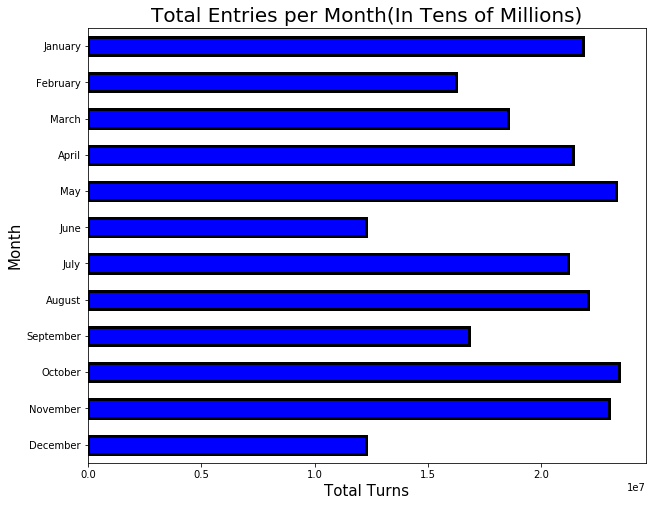

In [83]:
plt.figure(figsize=(10, 8))

df.groupby(['month'])['total_turns'].sum()[reversed(months)].plot(kind = 'barh', colors = 'blue', edgecolor='black',
                                                               linewidth='3')
plt.title('Total Entries per Month(In Tens of Millions)',fontsize = 20)
plt.xlabel('Total Turns', fontsize = 15)
plt.ylabel('Month',fontsize = 15)


Our inital graph shown above is to see which months generate the most turns per station. What we see is sort of what we expected, we see the lowest months being in both june and december which would make sense. June turns should be down due to the beginning of summer happening and less people possibly being around as well as December being a low month due to people taking off for the holiday break. Towards the end of year shows two of the top 3 months with the highest turns being in October and November which could indicate the right time period for a move to be made.

In [84]:
day = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday']

Text(0, 0.5, 'day')

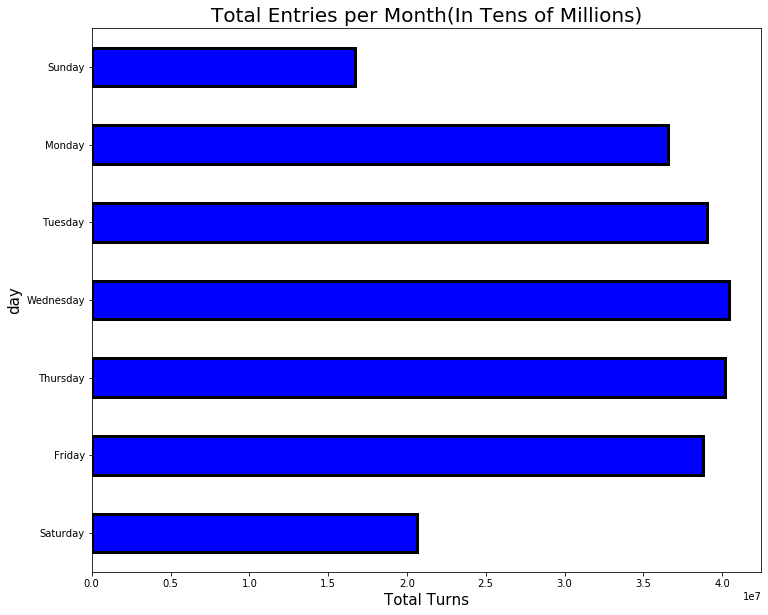

In [85]:
plt.figure(figsize=(12, 10))

df.groupby(['day'])['total_turns'].sum()[reversed(day)].plot(kind = 'barh', colors = 'blue', edgecolor='black',
                                                               linewidth='3')
plt.title('Total Entries per Month(In Tens of Millions)',fontsize = 20)
plt.xlabel('Total Turns', fontsize = 15)
plt.ylabel('day',fontsize = 15)

When we see the turns by day, Saturday and Sunday were expecte to see the slowest activity given that these are non-work days for most people. Interesting enough is to see how the gradual increase up to Wednesday being the peak and then a gradually decrease back down. Activity is telling as it can show people maybe with more flexible working arrangements maybe needing to come in for a day a week to meet with their perspective teams. 

In [86]:
stations_names = df['Station'].sort_values().unique()
stations_names

array(['14 ST', '23 ST', '34 ST-PENN STA', '42 ST-PORT AUTH',
       '5 AV/53 ST', '50 ST', '7 AV', '75 AV', '8 AV', 'BRIARWOOD',
       'CANAL ST', 'CHAMBERS ST', 'COURT SQ-23 ST', 'FOREST HILLS 71',
       'JFK JAMAICA CT1', 'JKSN HT-ROOSVLT', 'KEW GARDENS',
       'LEXINGTON AV/53', 'QUEENS PLAZA', 'SPRING ST', 'TIMES SQ-42 ST',
       'W 4 ST-WASH SQ', 'WORLD TRADE CTR'], dtype=object)

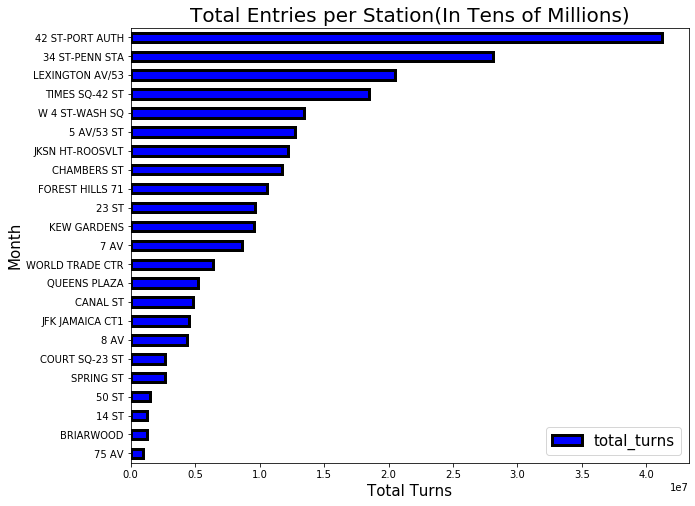

In [87]:
plt.figure(figsize=(10, 8))

df.groupby(['Station'])['total_turns'].sum().sort_values().plot(kind = 'barh', colors = 'blue', edgecolor='black',
                                                               linewidth='3')
plt.title('Total Entries per Station(In Tens of Millions)',fontsize = 20)
plt.xlabel('Total Turns', fontsize = 15)
plt.ylabel('Month',fontsize = 15)
plt.legend(fontsize = 15);

Per what we expected, the port authority terminal station as well as the Penn Station station had the top two total turns. Beneath that, you'll notice that the next real 'tier' of stops were all basically manhattan stops, which would make sense due to majority of people working in the city. The first station on that list that isnt in manhattan is the Jackson Avenue station and something that we will want to dig in a little more below tok see the average distance of starbucks in that area. But from this graph, we will examine port authroity as a means of seeing what a high turnstile area looks like as one of our case studies.

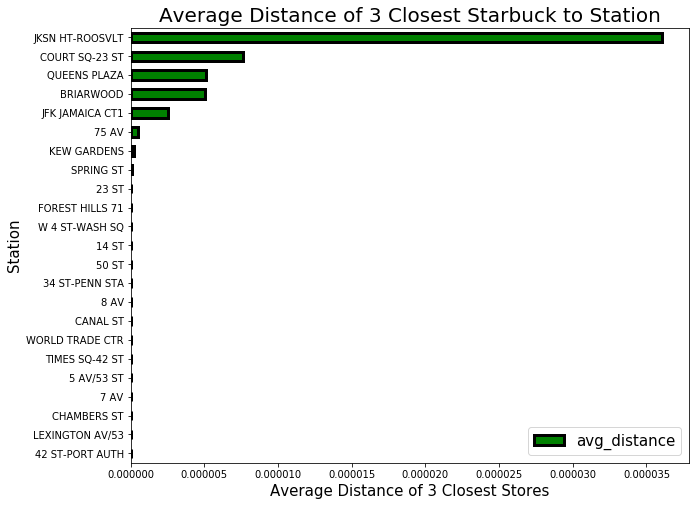

In [88]:
plt.figure(figsize=(10, 8))

df.groupby(['Station'])['avg_distance'].mean().sort_values().plot(kind = 'barh', colors = 'green', edgecolor='black',
                                                               linewidth='3')
plt.title('Average Distance of 3 Closest Starbuck to Station',fontsize = 20)
plt.xlabel('Average Distance of 3 Closest Stores', fontsize = 15)
plt.ylabel('Station',fontsize = 15)
plt.legend(fontsize = 15,loc = 'lower right');

When looking at this graph, the NYC stations should be more towards the bottom of this list as expected because of there being more stores located within manhattan and closer together. What I did not expect to see was that the station with the most turnstiles that wasnt located in manhattan, which is Jackson Hiehgts, would be at the top of this list as the the station witht the furtheset total starbucks. This was something that stood out and was the station that we needed to look into further to see if there was an upward trajectory in our foot turnstile metric created to see if there would be a growing oppertunity there.

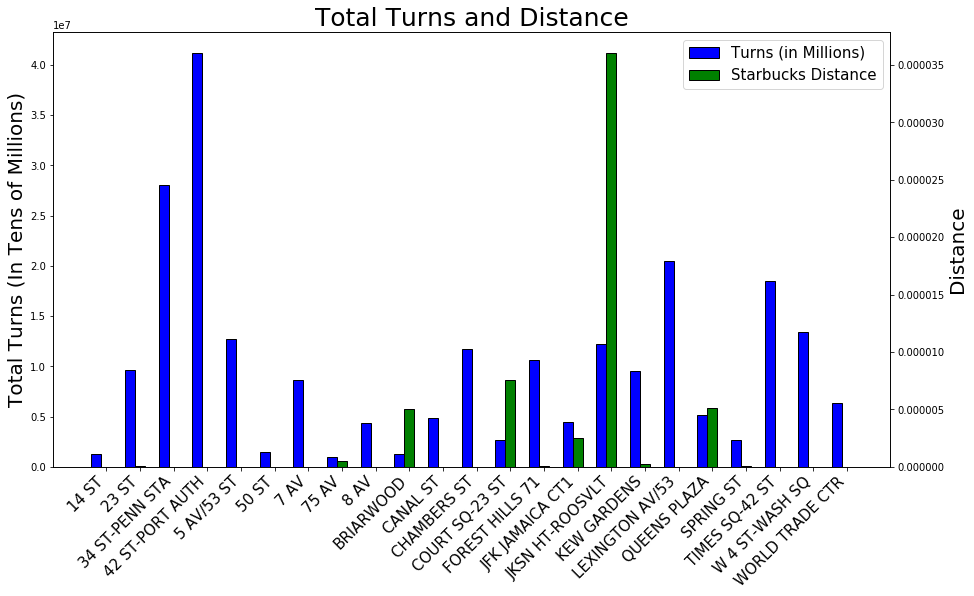

In [89]:
# Have two sets of data we want to plot
bars1 = df.groupby(['Station'])['total_turns'].sum()
bars2 = df.groupby(['Station'])['avg_distance'].mean()
barWidth = .3

# arange x values to be plotted
b1 = np.arange(len(bars1))
b2 = [x + barWidth for x in b1]
b3 = b1+b2 

#Set up Graph
fig = plt.figure(figsize = (15,8))
ax = plt.subplot(111)


# Create Total Turns bar
ax.bar(b1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Turns (in Millions)')
plt.xticks([r + barWidth for r in range(len(b3))], stations_names, rotation=45,fontsize = 15)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.yticks(fontsize = 10)
plt.ylabel('Total Turns (In Tens of Millions)', fontsize = 20)
# Create Starbucks Distance
ax2 = ax.twinx()
ax2.bar(b2, bars2, width = barWidth, color = 'green', edgecolor = 'black', capsize=7, label='Starbucks Distance')
plt.ylabel('Distance', fontsize = 20)

plt.title("Total Turns and Distance",  fontsize= 25)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0, fontsize = 15)

plt.show()


With the graph above, its just more of insurance for people to see the relation of the two prior graphs being side by side with eachother. As you see, Jackson Heights show the most activity between the turn and average distance metrics

In [90]:
fol = df.groupby('Station').mean().reset_index()
fol2 = df.groupby('Station').sum().reset_index()
fol.head()

,Station,Station_Latitude,Station_Longitude,first_closest,second_closest,third_closest,Entries,Exits,total_turns,avg_distance
0,14 ST,40.740893,-74.001690,0.001861,0.002499,0.003523,1586.097179,2408.758621,3994.855799,1.638377e-08
1,23 ST,40.745906,-73.998041,0.003181,0.003717,0.003729,1204.652737,833.162919,2037.815655,4.408462e-08
2,34 ST-PENN STA,40.752287,-73.993391,0.001281,0.001281,0.003779,1136.768325,1082.399700,2219.168024,6.205325e-09
3,42 ST-PORT AUTH,40.757308,-73.989735,0.000612,0.000680,0.001043,1587.264095,1140.270447,2727.534542,4.339208e-10
4,5 AV/53 ST,40.760167,-73.975224,0.001516,0.001719,0.001915,909.374301,1011.256085,1920.630385,4.990736e-09


In [91]:
lat = [coors for coors in fol['Station_Latitude']]
long = [coors for coors in fol['Station_Longitude']]
coors = (pd.DataFrame({'lat': lat,'long':long}))
points = list(zip(coors['lat'], coors['long']))

In [92]:
m = folium.Map(location=[40.693943, -73.985880], default_zoom_start=10)

for i in range(0,len(fol)):
    folium.Circle(
        location=[fol.iloc[i]['Station_Latitude'], fol.iloc[i]['Station_Longitude']],
        popup=fol.iloc[i]['Station'],
        radius=fol2.iloc[i]['total_turns']/90000,
        color='crimson',
        fill=True,
        fill_color='crimson'
   ).add_to(m)
    folium.Marker(
        location=[fol.iloc[i]['Station_Latitude'], fol.iloc[i]['Station_Longitude']],
        popup=fol.iloc[i]['Station'],
        tooltip = "Station"
   ).add_to(m)
    
m

http://web.mta.info/nyct/service/eline.htm

### Port Authority

Per above, our first station that we would like to look into will be Port Auhtority as it has shown the highet number of turn in the area.

In [93]:
df.head()

,C/A,Unit,SCP,Station,Line Name,Division,month,day,Station_Latitude,Station_Longitude,first_closest,first_closest_store,second_closest,second_closest_store,third_closest,third_closest_store,Entries,Exits,total_turns,avg_distance
Date,,,,,,,,,,,,,,,,,,,,
2016-12-31,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,December,Saturday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,622,1607,2229,5.150430e-09
2017-01-01,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Sunday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,767,1568,2335,5.150430e-09
2017-01-02,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Monday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,1192,1808,3000,5.150430e-09
2017-01-03,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Tuesday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,3193,3895,7088,5.150430e-09
2017-01-04,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Wednesday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,3124,4108,7232,5.150430e-09


In [94]:
port = df[df['Station'] == '42 ST-PORT AUTH']

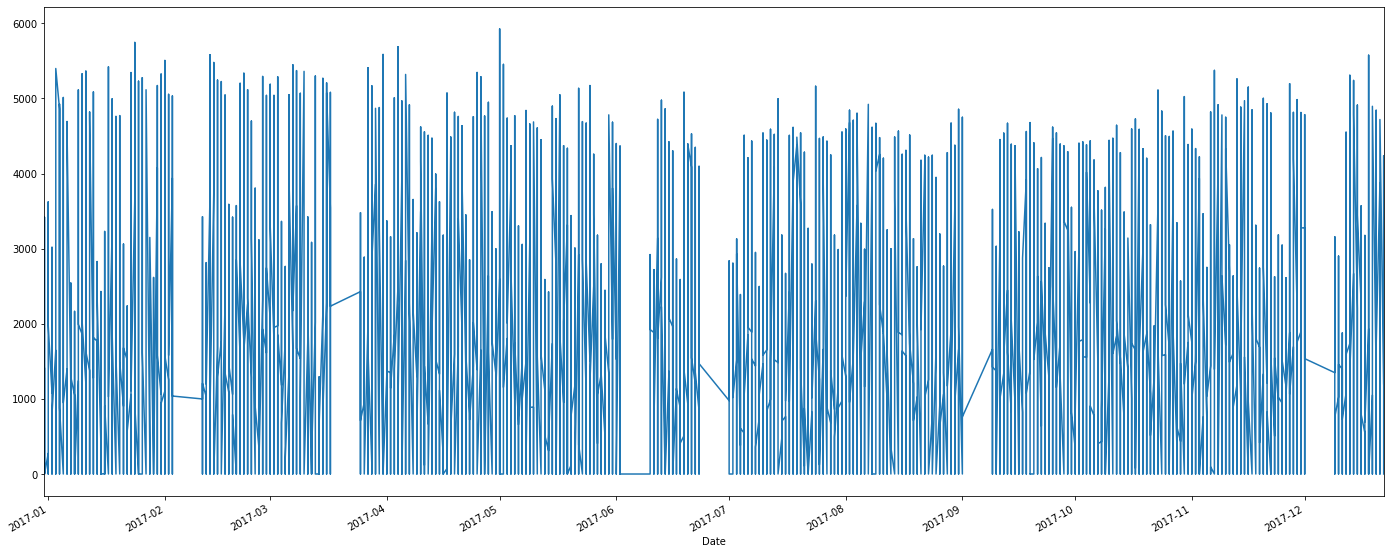

In [95]:
plt.figure(figsize=(24,10))
port['Entries'].plot()

Text(0, 0.5, 'Day of Week')

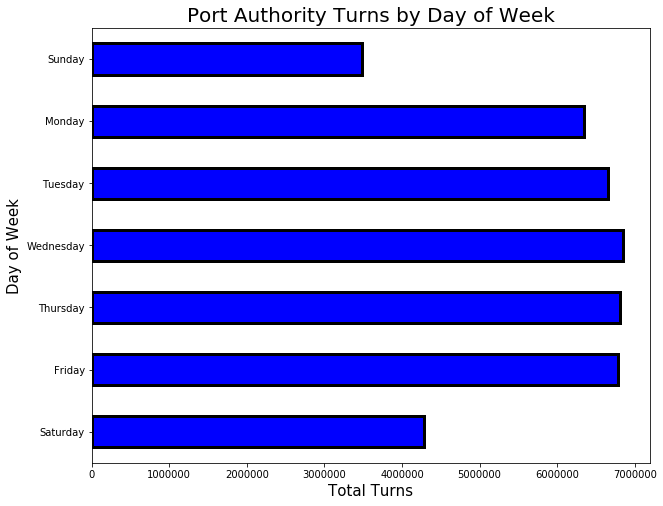

In [96]:
plt.figure(figsize=(10, 8))
port.groupby('day')['total_turns'].sum()[reversed(day)].plot(kind = 'barh', colors = 'blue', edgecolor='black',
                                                               linewidth='3')
plt.title('Port Authority Turns by Day of Week', fontsize = 20)
plt.xlabel('Total Turns', fontsize = 15)
plt.ylabel('Day of Week', fontsize = 15)

In [97]:
port1 = df.loc[df['Station'] == '42 ST-PORT AUTH',:].groupby('Date').sum()

In [98]:
port1

,Station_Latitude,Station_Longitude,first_closest,second_closest,third_closest,Entries,Exits,total_turns,avg_distance
Date,,,,,,,,,
2016-12-31,1997.108092,-3625.497015,0.029978,0.033334,0.051087,64566,45238,109804,2.126212e-08
2017-01-01,1997.108092,-3625.497015,0.029978,0.033334,0.051087,48202,37811,86013,2.126212e-08
2017-01-02,1997.108092,-3625.497015,0.029978,0.033334,0.051087,53122,38180,91302,2.126212e-08
2017-01-03,1997.108092,-3625.497015,0.029978,0.033334,0.051087,95763,64798,160561,2.126212e-08
2017-01-04,1997.108092,-3625.497015,0.029978,0.033334,0.051087,93185,62397,155582,2.126212e-08
...,...,...,...,...,...,...,...,...,...
2017-12-18,1956.350784,-3551.507280,0.029366,0.032653,0.050044,91165,61849,153014,2.082820e-08
2017-12-19,1956.350784,-3551.507280,0.029366,0.032653,0.050044,90191,62946,153137,2.082820e-08
2017-12-20,1956.350784,-3551.507280,0.029366,0.032653,0.050044,90403,64067,154470,2.082820e-08


(array([736330., 736361., 736389., 736420., 736450., 736481., 736511.,
        736542., 736573., 736603., 736634., 736664.]),
 <a list of 12 Text xticklabel objects>)

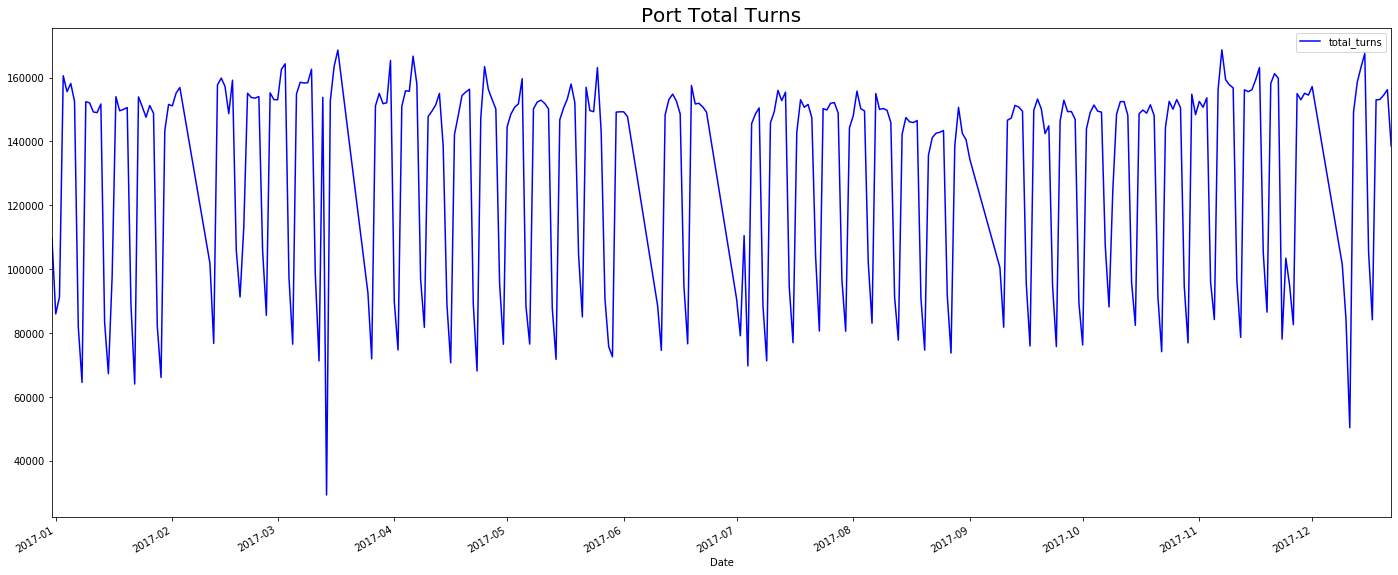

In [99]:
plt.figure(figsize=(24,10))
port1['total_turns'].plot(color = 'blue', legend = True)
plt.title('Port Total Turns', fontsize = 20)
plt.xticks(fontsize = 10)

In [100]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18, rotation = 45);

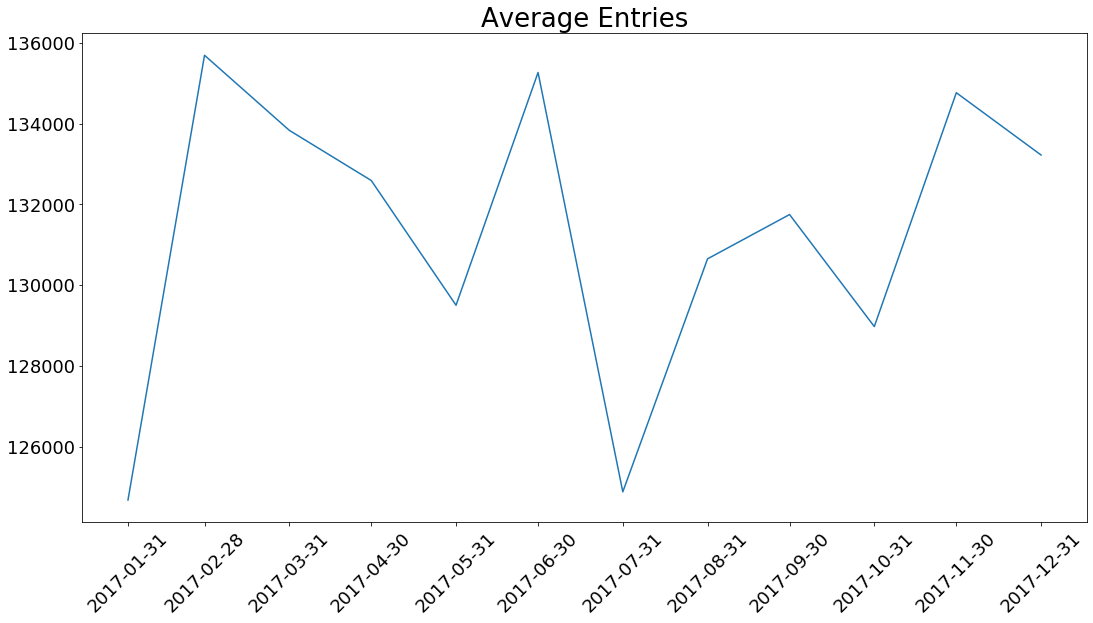

In [101]:
plot_series(port1.resample('M', closed = 'left').mean(),
            ['total_turns'],
            title = 'Average Entries',
            steps = 1)

In [102]:
port1['rolling_month_turns'] = port1['total_turns'].rolling(30).mean()
port1['rolling_quarter_turns'] = port1['total_turns'].rolling(91).mean()

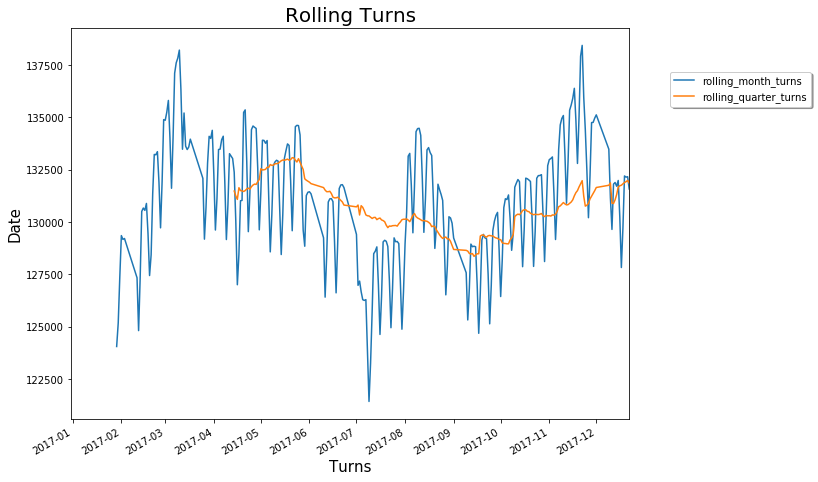

In [103]:
plt.figure(figsize = (10,8))
port1['rolling_month_turns'].plot()
port1['rolling_quarter_turns'].plot()
plt.title('Rolling Turns', fontsize = 20)
plt.xlabel('Turns', fontsize = 15)
plt.ylabel('Date', fontsize = 15)
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9), shadow=True, ncol=1);

In [104]:
port1 = df.loc[df['Station'] == '42 ST-PORT AUTH',:].groupby('Date').sum()

In [105]:
port1.shape

(315, 9)

In [106]:
port1.head()

,Station_Latitude,Station_Longitude,first_closest,second_closest,third_closest,Entries,Exits,total_turns,avg_distance
Date,,,,,,,,,
2016-12-31,1997.108092,-3625.497015,0.029978,0.033334,0.051087,64566,45238,109804,2.126212e-08
2017-01-01,1997.108092,-3625.497015,0.029978,0.033334,0.051087,48202,37811,86013,2.126212e-08
2017-01-02,1997.108092,-3625.497015,0.029978,0.033334,0.051087,53122,38180,91302,2.126212e-08
2017-01-03,1997.108092,-3625.497015,0.029978,0.033334,0.051087,95763,64798,160561,2.126212e-08
2017-01-04,1997.108092,-3625.497015,0.029978,0.033334,0.051087,93185,62397,155582,2.126212e-08


### Jackson Heights

Due to Jackson Heights having highest number of turnstiles as well as the the highest distance of Starbucks to the stations, we will look at Jackson Hieghts as a means of determining if this could be a viable station for the oppertunity to look into a starbucks.

In [107]:
df.head()

,C/A,Unit,SCP,Station,Line Name,Division,month,day,Station_Latitude,Station_Longitude,first_closest,first_closest_store,second_closest,second_closest_store,third_closest,third_closest_store,Entries,Exits,total_turns,avg_distance
Date,,,,,,,,,,,,,,,,,,,,
2016-12-31,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,December,Saturday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,622,1607,2229,5.150430e-09
2017-01-01,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Sunday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,767,1568,2335,5.150430e-09
2017-01-02,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Monday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,1192,1808,3000,5.150430e-09
2017-01-03,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Tuesday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,3193,3895,7088,5.150430e-09
2017-01-04,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,January,Wednesday,40.754672,-73.986754,0.001214,42nd btwn 3rd & Lex,0.001846,39th & 7th,0.002298,Broadway Btwn 37th & 38th,3124,4108,7232,5.150430e-09


In [108]:
jksn_ht = df[df['Station'] == 'JKSN HT-ROOSVLT']

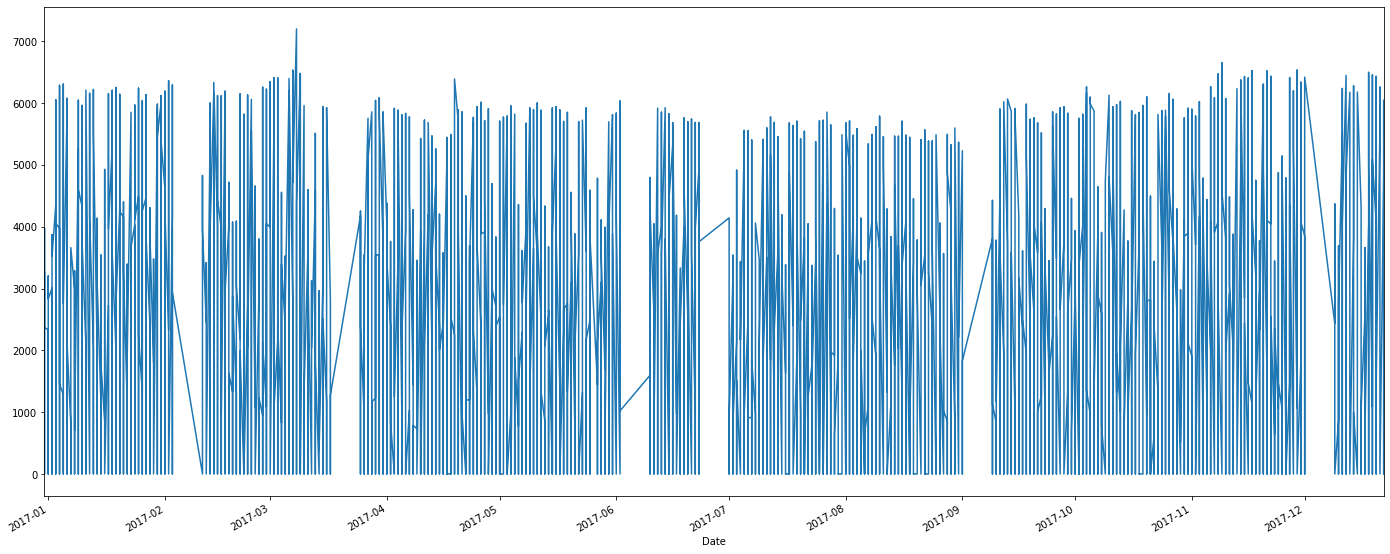

In [109]:
plt.figure(figsize=(24,10))
jksn_ht['total_turns'].plot()

Text(0, 0.5, 'Day of Week')

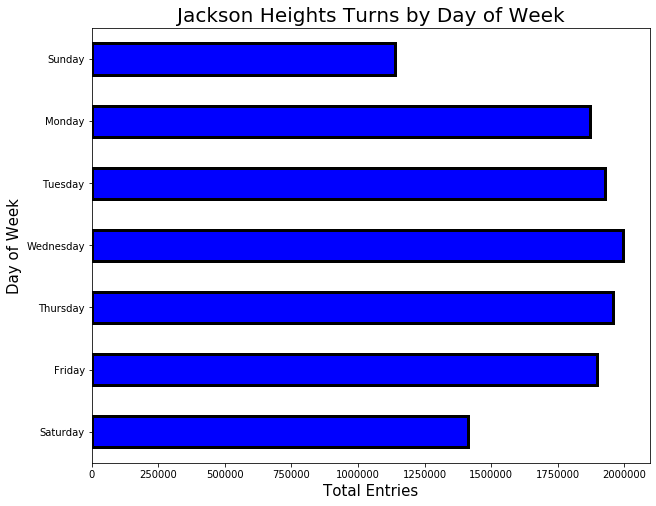

In [110]:
plt.figure(figsize=(10, 8))
jksn_ht.groupby('day')['total_turns'].sum()[reversed(day)].plot(kind = 'barh', colors = 'blue', edgecolor='black',
                                                               linewidth='3')
plt.title('Jackson Heights Turns by Day of Week', fontsize = 20)
plt.xlabel('Total Entries', fontsize = 15)
plt.ylabel('Day of Week', fontsize = 15)

In [111]:
jksn_ht1 = df.loc[df['Station'] == 'JKSN HT-ROOSVLT' ,:].groupby('Date').sum()

In [112]:
jksn_ht1.head()

,Station_Latitude,Station_Longitude,first_closest,second_closest,third_closest,Entries,Exits,total_turns,avg_distance
Date,,,,,,,,,
2016-12-31,611.19966,-1108.37007,0.451082,0.501957,0.537558,19529,13157,32686,0.000541
2017-01-01,611.19966,-1108.37007,0.451082,0.501957,0.537558,13716,10923,24639,0.000541
2017-01-02,611.19966,-1108.37007,0.451082,0.501957,0.537558,17501,12802,30303,0.000541
2017-01-03,611.19966,-1108.37007,0.451082,0.501957,0.537558,28551,19540,48091,0.000541
2017-01-04,611.19966,-1108.37007,0.451082,0.501957,0.537558,30522,20932,51454,0.000541


Text(0.5, 0, 'Total Turns')

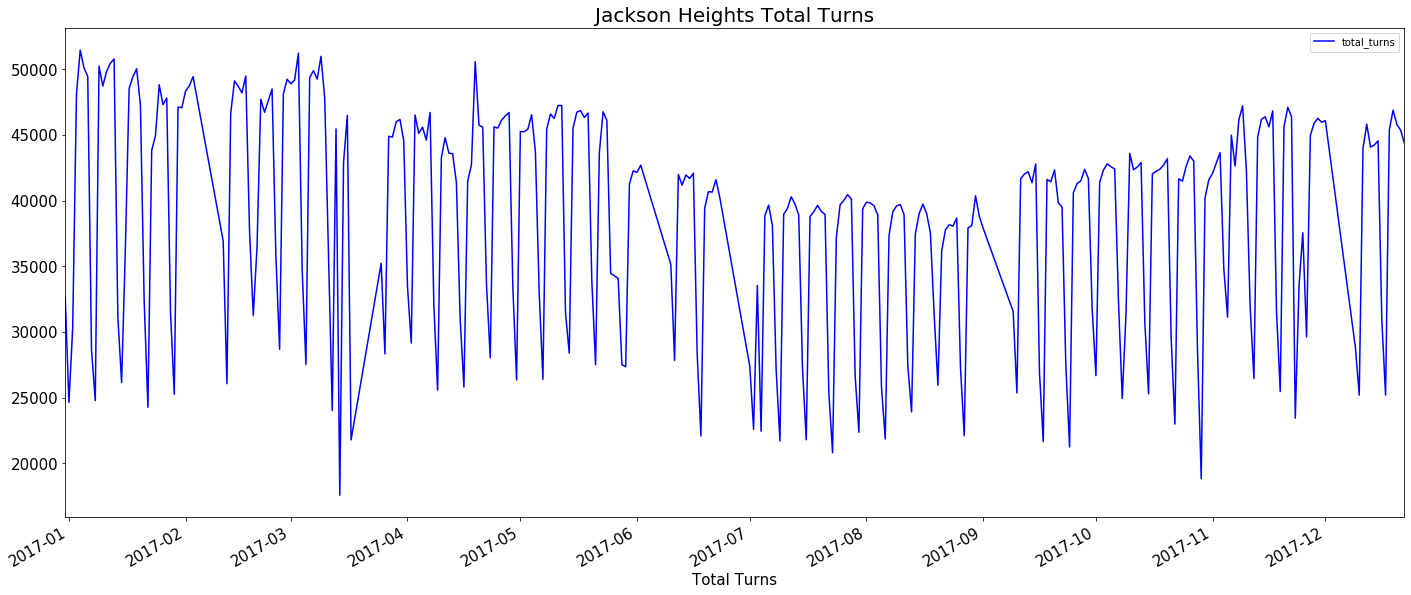

In [113]:
plt.figure(figsize=(24,10))
jksn_ht1['total_turns'].plot(color = 'blue', legend = True)
plt.title('Jackson Heights Total Turns', fontsize = 20)
plt.xlabel('Total Turns',fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Total Turns',fontsize = 15)

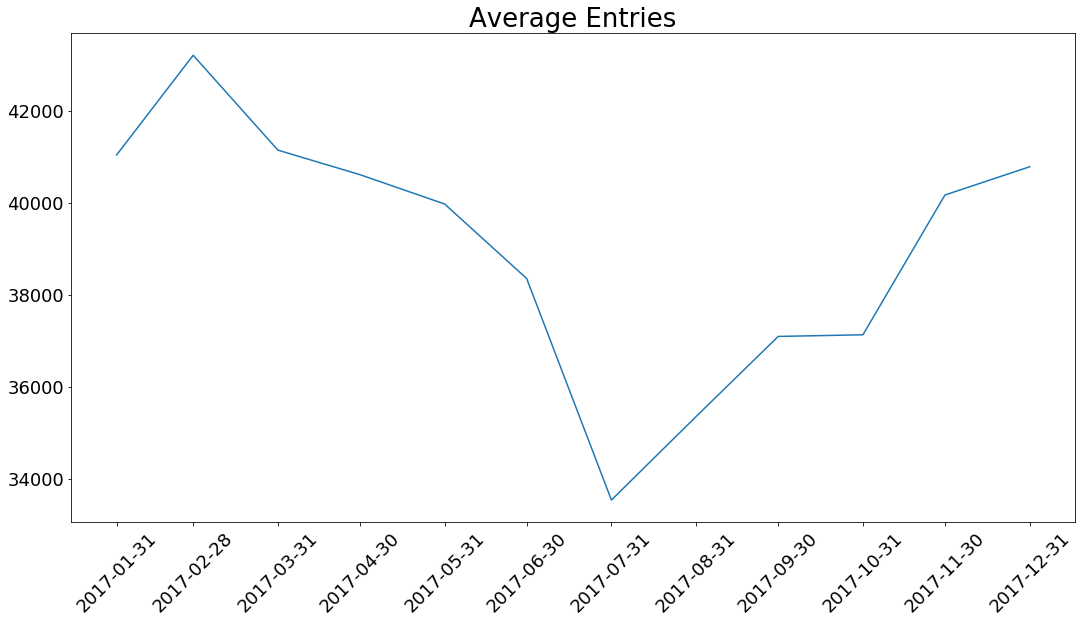

In [114]:
plot_series(jksn_ht1.resample('M', closed = 'left').mean(),
            ['total_turns'],
            title = 'Average Entries',
            steps = 1)

In [115]:
jksn_ht1['rolling_month_turns'] = jksn_ht1['total_turns'].rolling(30).mean()
jksn_ht1['rolling_quarter_turns'] = jksn_ht1['total_turns'].rolling(91).mean()

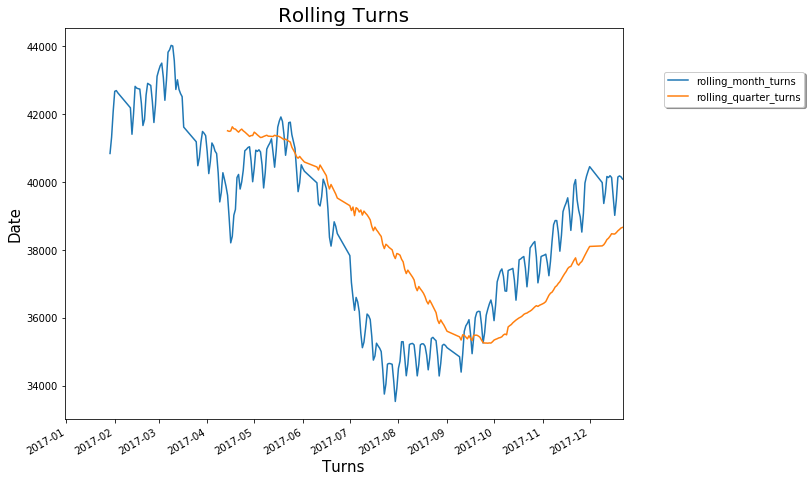

In [116]:
plt.figure(figsize = (10,8))
jksn_ht1['rolling_month_turns'].plot()
jksn_ht1['rolling_quarter_turns'].plot()
plt.title('Rolling Turns', fontsize = 20)
plt.xlabel('Turns', fontsize = 15)
plt.ylabel('Date', fontsize = 15)
plt.legend(loc='upper center', bbox_to_anchor=(1.2, .9), shadow=True, ncol=1);

## Modelings

For our modeling stage, we are going to look to fit an ARIMA as well as an SARIMAX model to judge on at both Port Authority adn Jackson Heights.

### Port Authority

__Baseline Model__

In [117]:
def baseline_model(df):
    dummy = pd.DataFrame({0:df['total_turns'], 1: df['total_turns'].mean()})
    return print(f' Our baseline model RMSE is {np.sqrt(mean_squared_error(dummy[0], dummy[1]))}')

In [118]:
baseline_model(port1)

 Our baseline model RMSE is 31979.67739142347


By establishing our baseline, we are looking to build models that will score better than an RMSE of 31,980

One of the first things we wanted to look at was to see if there was stationarity in our data. To do this, we will want to perform the Augmented Dickey-Fuller Test which is a hypthesis test that will be run and what we would like to see is a small P-value on our y-variable so we can reject the null hypothesis and state that the data is stationary. We determine that a value of .05 and lower will reject the null hypthesis 

In [119]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [120]:
interpret_dftest(adfuller(port1['total_turns']))

Test Statistic   -4.673698
p-value           0.000094
dtype: float64

As we can see, our P-Value is below our threshold of .05 which means we are able to determine that our data is in fact stationary and will not have to be differed to be performing models.

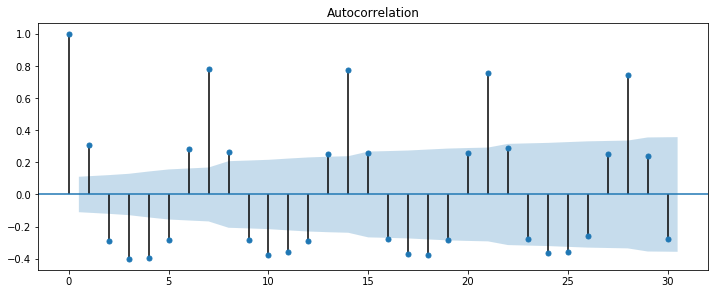

In [121]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
fig = plot_acf(port1['total_turns'], lags=30, ax=ax1);

When also looking at this graph, points that are within the blue curve represent 95% cofidence interval for these correlations. Points that are outside this curve mean that there is a significan correlation betwen our turns and previous lags.  As you can see there is seasonality that occurs every 7 days within our data which does make it had to determine a value that we can have. Because of this, we will look at our PACF to see if we determine one that way.




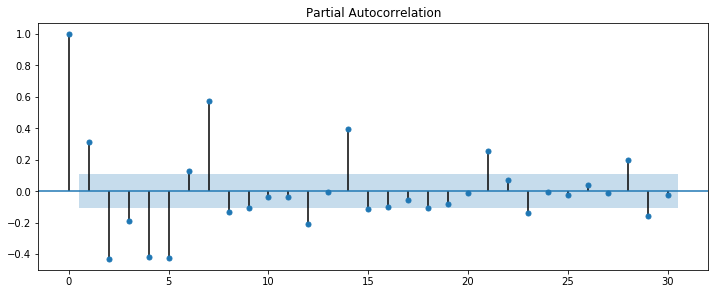

In [122]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
fig = plot_pacf(port1['total_turns'], lags=30, ax=ax1);

Due to the seaonality compnent of the PACF shown every 7 days, we are unable to interpret a P value from our graph as there is a clear spike within our data. Because of this, we will have to mannually perform a grid search over the data to determine our optimal P value.

#### Port ARIMA

In [123]:
port_train, port_test = train_test_split(port1['total_turns'], test_size = 0.25, shuffle = False)

In [124]:
len(port_train)

236

In [125]:
len(port_test)

79

In [126]:
port_test.head()

Date
2017-09-28    149352
2017-09-29    146903
2017-09-30     89381
2017-10-01     76296
2017-10-02    143937
Name: total_turns, dtype: int64

In [127]:
port_test.index[67]

Timestamp('2017-12-11 00:00:00')

In [128]:
port_test.drop(port_test.index[67], axis = 0, inplace = True)

In [129]:
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train, c='blue')
    plt.plot(test, c='orange')

This will be a funcation that we will be able to use to plot our train and test data

Text(0.5, 1.0, 'Train Test Plot of Total Turns')

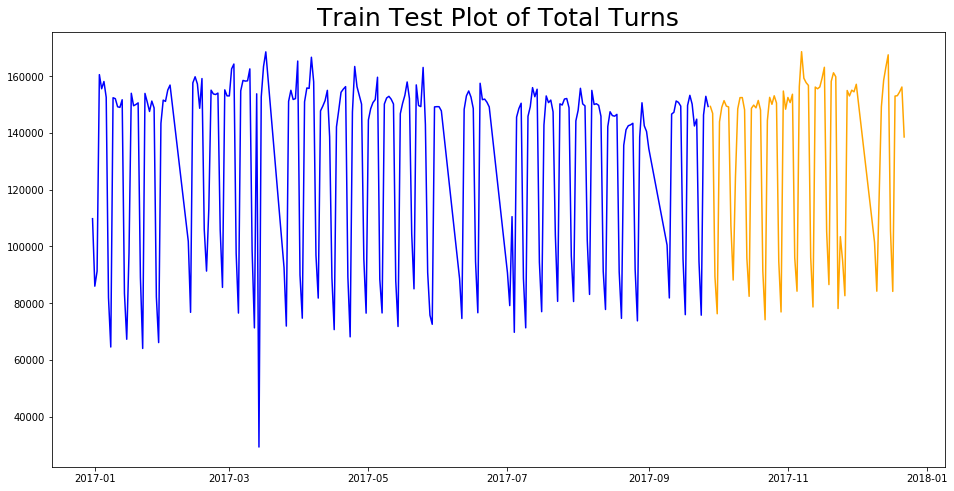

In [130]:
train_test_plot(port_train, port_test)
plt.title('Train Test Plot of Total Turns', fontsize = 25)



In [131]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range (0,7):
    for q in range (0,7):
        
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 0, q) model.
            print(f'Attempting to fit ARIMA({p}, 0, {q}) Model')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = port_train.astype(float).dropna(),  ##endog = y - variable
                         order = (p, 0, q))
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},0,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},0,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0, 0, 0) Model
The AIC for ARIMA(0,0,0) is: 5572.484065568603
Attempting to fit ARIMA(0, 0, 1) Model
The AIC for ARIMA(0,0,1) is: 5529.778056775479
Attempting to fit ARIMA(0, 0, 2) Model
The AIC for ARIMA(0,0,2) is: 5515.090096420732
Attempting to fit ARIMA(0, 0, 3) Model
The AIC for ARIMA(0,0,3) is: 5481.78144855227
Attempting to fit ARIMA(0, 0, 4) Model
Attempting to fit ARIMA(0, 0, 5) Model
Attempting to fit ARIMA(0, 0, 6) Model
Attempting to fit ARIMA(1, 0, 0) Model
The AIC for ARIMA(1,0,0) is: 5552.530461394445
Attempting to fit ARIMA(1, 0, 1) Model
The AIC for ARIMA(1,0,1) is: 5529.984185711405
Attempting to fit ARIMA(1, 0, 2) Model
The AIC for ARIMA(1,0,2) is: 5495.021126689071
Attempting to fit ARIMA(1, 0, 3) Model
The AIC for ARIMA(1,0,3) is: 5483.764526424297
Attempting to fit ARIMA(1, 0, 4) Model
The AIC for ARIMA(1,0,4) is: 5480.487696418872
Attempting to fit ARIMA(1, 0, 5) Model
The AIC for ARIMA(1,0,5) is: 5467.816631819332
Attempting to fit ARIMA(

In [132]:
best_arima = ARIMA(endog = port_train.astype(float),
              order = (6, 0, 6))
best_arima_fit = best_arima.fit()

In [133]:
port_preds_arima = best_arima_fit.forecast(steps = len(port_test))[0]

In [134]:
port_arima_error = np.sqrt(mean_squared_error(port_test, port_preds_arima))
print(f'RMSE: {round(port_arima_error, 2)}')

RMSE: 15420.69


#### Port Sarmimax

With our SARIMAX model, we note that we will not be adding a egogin

In [ ]:
# Starting RMSE, p, and q.
final_rmse = 99 * (10 ** 16)
best_P = 0
best_Q = 0
# Use nested for loop to iterate over values of P and Q.
for P in range (7):
    for Q in range (7):



    # Insert try and except statements.
        try:

            # Fitting an SARIMA (P, 0, Q, 12) model.
            print(f'Attempting to fit SARIMA({P}, 0, {Q}, 7) Model')

            # Instantiate SARIMA model.
            best_sarimax = SARIMAX(endog = port_train,
                       order = (6, 0, 6),
                       seasonal_order = (P,0,Q, 7))

            model = best_sarimax.fit()
            sarimax_pred = model.forecast(steps = len(port_test))
            # Print out RMSE for SARIMA(P, D, Q,12) model.
            # Evaluate predictions.
            print(f'The RMSE for (6, 0, 6)x({P},0,{Q},12) is: {np.sqrt(mean_squared_error(port_test, sarimax_pred))}')
            # Is my current model's RMSE better than our best_RMSE?

            if np.sqrt(mean_squared_error(port_test, sarimax_pred)) < final_rmse:
                # If so, let's overwrite best_RMSE best_p, and best_q.
                final_rmse = np.sqrt(mean_squared_error(port_test, sarimax_pred))
                best_P = P
                best_Q = Q
        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes RMSE on the training data is the SARIM({best_P},0,{best_Q}, 7).')
print(f'This model has an RMSE of {final_rmse}.')

Attempting to fit SARIMA(0, 0, 0, 7) Model
The RMSE for (6, 0, 6)x(0,0,0,12) is: 17193.527741883594
Attempting to fit SARIMA(0, 0, 1, 7) Model
The RMSE for (6, 0, 6)x(0,0,1,12) is: 16945.48979637168
Attempting to fit SARIMA(0, 0, 2, 7) Model
The RMSE for (6, 0, 6)x(0,0,2,12) is: 29177.61998483195
Attempting to fit SARIMA(0, 0, 3, 7) Model
The RMSE for (6, 0, 6)x(0,0,3,12) is: 28486.48819005235
Attempting to fit SARIMA(0, 0, 4, 7) Model
The RMSE for (6, 0, 6)x(0,0,4,12) is: 27631.3524557755
Attempting to fit SARIMA(0, 0, 5, 7) Model
The RMSE for (6, 0, 6)x(0,0,5,12) is: 27402.71790671975
Attempting to fit SARIMA(0, 0, 6, 7) Model
The RMSE for (6, 0, 6)x(0,0,6,12) is: 25702.361661315255
Attempting to fit SARIMA(1, 0, 0, 7) Model
The RMSE for (6, 0, 6)x(1,0,0,12) is: 17719.60303939802
Attempting to fit SARIMA(1, 0, 1, 7) Model
The RMSE for (6, 0, 6)x(1,0,1,12) is: 15362.620480672884
Attempting to fit SARIMA(1, 0, 2, 7) Model
The RMSE for (6, 0, 6)x(1,0,2,12) is: 15818.766678600234
Attempt

In [ ]:
Based on the gridsearch performed above, we will fit a model 

In [ ]:
best_sarimax = SARIMAX(endog = port_train,
                       order = (6, 0, 6),
                       seasonal_order = (1,0,1, 7))

best_sarimax_fit = best_sarimax.fit()

sarimax_pred = best_sarimax_fit.predict(start = len(port_train),
                            end = len(port_train) + len(port_test) - 1,
                            dynamic = True)

In [ ]:
port_sarimax_error = np.sqrt(mean_squared_error(port_test, sarimax_pred))
print(f'RMSE: {round(port_sarimax_error, 2)}')

In [ ]:
port_sarimax_pred_forcasting = model.predict(start = len(port_train),
                            end = len(port_train) + 150,
                            dynamic = True)

the residual plots that we are making above are points that extend past our test set that we are able to see to make future predictions about 2018

### Jackson Heights

In [ ]:
baseline_model(jksn_ht1)

for our Jackson Heights model, we are looking to beat an RMSE score of 8,230

One of the first things we wanted to look at was to see if there was stationarity in our data. To do this, we will want to perform the Augmented Dickey-Fuller Test which is a hypthesis test that will be run and what we would like to see is a small P-value on our y-variable so we can reject the null hypothesis and state that the data is stationary. We determine that a value of .05 and lower will reject the null hypthesis 

In [ ]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [ ]:
interpret_dftest(adfuller(jksn_ht1['total_turns']))

As we see here with our test, our p-Value is above the .05 mark which means our data is not staitonary, as a result, we will have to diff our data once to see if we can obtain stationarity

In [ ]:
jksn_ht1['diff_1'] = jksn_ht1['total_turns'].diff(1)

In [ ]:
interpret_dftest(adfuller(jksn_ht1['diff_1'].dropna()))

After the diff, we can see our P-Value is below our threshold of .05. When we now run both our ARIMA and SARIMA model, we will input a D value of 1

In [ ]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
fig = plot_acf(jksn_ht1['diff_1'].dropna(), lags=30, ax=ax1);

Similarly to what we saw in the ACF of Port Authority, we can tell that thre is seasonality within our data and that we will run again both an ARIMA and a SARIMA mode. 



In [ ]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
fig = plot_pacf(jksn_ht1['diff_1'].dropna(), lags=30, ax=ax1);

Due to the seaonality compnent of the PACF shown every 7 days, we are unable to interpret a P value from our graph as there is a clear spike within our data. Because of this, we will have to mannually perform a grid search over the data to determine our optimal P value.

#### Jackson Heights ARIMA

In [ ]:
jack_train, jack_test = train_test_split(jksn_ht1['total_turns'], test_size = 0.25, shuffle = False)

In [ ]:
train_test_plot(jack_train, jack_test)
plt.title('Train Test Plot of Total Turns', fontsize = 25)
plt.xlabel ('Date', fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel ('Total Turns', fontsize = 15)
plt.yticks(fontsize = 15)
plt.hlines(y = jksn_ht1['total_turns'].mean(), xmin=jksn_ht1.index[0], xmax = jksn_ht1.index[-1], color = 'green')


In [ ]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range (0,7):
    for q in range (0,7):
        
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 0, q) model.
            print(f'Attempting to fit ARIMA({p}, 1, {q}) Model')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = jack_train.astype(float).dropna(),  ##endog = y - variable
                         order = (p, 1, q))
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

In [ ]:
best_arima_jack = ARIMA(endog = jack_train.astype(float),
              order = (6, 1, 4))
best_arima_fit_jack = best_arima_jack.fit()

In [ ]:
jack_preds = best_arima_fit_jack.predict(start = len(jack_train),
                            end = len(jack_train) + len(jack_test) - 1,
                            dynamic = True)

In [ ]:
jack_arima_error = np.sqrt(mean_squared_error(jack_test, jack_preds ))
print(f'RMSE: {round(jack_arima_error, 2)}')

#### Jackson Heights Sarmimax

With our SARIMAX model, we note that we will not be adding an exogenous variable within our model as when we did, the model was not being optimized. we will add the seasonal component as 7 as our data is daily. 

In [ ]:
# Starting RMSE, P, and Q.
final_rmse = 99 * (10 ** 16)
best_P = 0
best_Q = 0
# Use nested for loop to iterate over values of P and Q.
for P in range (7):
    for Q in range (7):



    # Insert try and except statements.
        try:

            # Fitting an SARIMA (P, 1, Q, 7) model.
            print(f'Attempting to fit SARIMA({P}, 1, {Q}, 7) Model')

            # Instantiate SARIMA model.
            best_sarimax = SARIMAX(endog = jack_train,
                       order = (6, 1, 4),
                       seasonal_order = (P,1,Q, 7))

            model = best_sarimax.fit()
            sarimax_pred = model.forecast(steps = len(jack_test))
            # Print out RMSE for SARIMA(P, 1, Q,7) model.
            # Evaluate predictions.
            print(f'The RMSE for (6, 1, 4)x({P},1,{Q},7) is: {np.sqrt(mean_squared_error(jack_test, sarimax_pred))}')
            # Is my current model's RMSE better than our best_RMSE?

            if np.sqrt(mean_squared_error(jack_test, sarimax_pred)) < final_rmse:
                # If so, let's overwrite best_RMSE best_P, and best_Q.
                final_rmse = np.sqrt(mean_squared_error(jack_test, sarimax_pred))
                best_P = P
                best_Q = Q
        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes RMSE on the training data is the SARIMA({best_P},1,{best_Q}, 7).')
print(f'This model has an RMSE of {final_rmse}.')

In [ ]:
best_sarimax_jack = SARIMAX(endog = jack_train,
                       order = (6, 1, 4),
                       seasonal_order = (3,1,2, 7))

best_sarimax_jack_fit = best_sarimax_jack.fit()
jack_sarimax_pred = best_sarimax_jack_fit.predict(start = len(jack_train),
                            end = len(jack_train) + len(jack_test) - 1,
                            dynamic = True)

In [ ]:
jack_sarimax_error = np.sqrt(mean_squared_error(jack_test, jack_sarimax_pred))
print(f'RMSE: {round(jack_sarimax_error, 2)}')

In [ ]:
jack_sarimax_pred_forcasting = best_sarimax_jack_fit.predict(start = len(jack_train),
                            end = len(jack_train) + 150,
                            dynamic = True)

## Model Selection

For Model Selections, we will want to take hte lower RMSE scores of each stations models

### Port Model Selection

In [ ]:
port_score_df = pd.DataFrame({'Model':['ARIMA','SARIMA'], 'RMSE':[round(port_arima_error, 2),round(port_sarimax_error, 2)]})

In [ ]:
port_score_df

Out of both our models that were provided, we deemed that the best model to run in this situation would be our SARIMAX model with the lower of the two RMSE scores of 15,362.62. With this model, it was able to model the seasonality component we added into it. Since we are scoring based on Ligistric Regression, we will run our 

### Jackson Heights Model Selection

In [ ]:
jack_score_df = pd.DataFrame({'Model':['ARIMA','SARIMA'], 'RMSE':[round(jack_arima_error, 2),round(jack_sarimax_error, 2)]})

In [ ]:
jack_score_df

When looking at our model for Jackson Heights, we can see a clearer differnce in that the SARIMA model scored better then our ARIMA. Although our scores may look better and that we are having a smaller RMSE, this is only because there isnt as much activity happening at the Jackson Heights Station. For the purpose of selecting a model here, SARIMA will be our choice.

## Model Evaluation

### Port Authority

In evalution of our time series model, we will want to focus in on the plotting of our residuals as well as plotting our forecast to see if the model is correctly predicting the trends.


In [ ]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
port_resids = port_test.values - sarimax_pred.values

# Generate scatterplot of residuals.
plt.scatter(port_test.index, port_resids, c ='blue')

# Plot baseline at y=0.
plt.hlines(y = 0,
           color = 'orange',
           xmin = port_test.index.min(),
           xmax = port_test.index.max(),
           linestyles = '--')

# Set labels and axes.
plt.title('Residual Plot', fontsize= 25)
plt.xlabel('Date', fontsize = 20)
plt.xticks(fontsize=15)
plt.xlim(port_test.index.min(), port_test.index.max())
plt.yticks(fontsize=15)
plt.ylabel('T', fontsize = 20);

When evaluating the residuals plot, we notice that there are a few outliers in which the data is being skewed. The first of the two point located between 11-15 and 12-01 that are below -40,000, which means that our model is overpredicting the actual amounts by ~ -40,000 turns, are because of the thanksgiving holiday in which people arent as frequently coming to the city which our model wouldnt be able to predict. The point to the right of that which is off an estimated ~-100,000 is because on December 11th, 2017. There was a bomb threat at the port authority station which would lead to no one being able go through that subway stop. Due to the port authority threat being an abnormal activity. We can say that it would be safe to drop the point as this is something that we would not expect to happen in real life

In [ ]:
# Plot the Predict Test vs actual model
plt.figure(figsize=(8,6))

plt.scatter(sarimax_pred, port_test, s=5, color='blue',marker = '+', alpha = 0.8)

plt.plot([0, np.max(port_test)],
         [0, np.max(port_test)],
         color = 'black')
plt.xlabel("Predicted Values: Total Turns", fontsize = 20)
plt.ylabel("Actual Values: Total Turns", fontsize = 20)
plt.title('Predicted Values vs. Actual Values: Test', fontsize = 24)
plt.tight_layout();

The plot above also shows how our predicted faired against the actual values. What we want to see here is that points are relatively close to our line of best fit that is shown within our model. 

In [ ]:

# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2,figsize = (12,8), sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# Add a graph in each part
sns.boxplot(port_resids, ax=ax_box)
sns.distplot(port_resids, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.axvline(x = 0, c = 'red')
plt.title('Distirbution of Residuals', fontsize = 25)
plt.xlabel('Residual',fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Frequency',fontsize = 15)
plt.yticks(fontsize = 15)


As we can see from a dsitribution of our residuals, we can see that there is a few points that are ourside of the normal dsitribution due to holidays that occur every year 

In [ ]:
plt.figure(figsize=(16, 8))
preds = pd.DataFrame(sarimax_pred_forcasting.values, index= pd.date_range(start = '2017-09-28', periods = 151), columns = ['total_turns'])
plt.plot(port_train.rolling(30).mean(), color = 'b', )
plt.plot(port_test.rolling(30).mean(), c='purple')
plt.plot(preds.rolling(30).mean(), color = 'orange')
plt.title(label = 'Total Turns with SARIMA(6, 0, 6) x (1, 0, 1, 7) Train, Test, and Predictions (Based on 30 Day Rolling Avereage)', fontsize=20)
plt.xlabel('Date', fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel('Total Turns', fontsize = 15)
plt.yticks(fontsize = 12)
plt.hlines(y = port1['total_turns'].mean(), xmin=port1.index[0], xmax = port1.index[-1], color = 'green');

While looking at this data

In [ ]:
plt.figure(figsize=(16, 8))

plt.plot(port_test.rolling(60).mean(), c='blue')
plt.plot(preds.rolling(60).mean(), c='orange')
plt.title(label = 'Total Turns with SARIMA(6, 0, 6) x (1, 0, 1, 7) Test and Predictions', fontsize=20)
plt.xlabel('Date', fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel('Total Turns', fontsize = 15)
plt.yticks(fontsize = 12);

### Jackson Heights

In evalution of our time series model, we will want to focus in on the plotting of our residuals as well as plotting our forecast to see if the model is correctly predicting the trends.


In [ ]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
jack_resids = jack_test.values - jack_sarimax_pred.values

# Generate scatterplot of residuals.
plt.scatter(jack_test.index, jack_resids, c ='blue')

# Plot baseline at y=0.
plt.hlines(y = 0,
           color = 'orange',
           xmin = jack_test.index.min(),
           xmax = jack_test.index.max(),
           linestyles = '--')

# Set labels and axes.
plt.title('Residual Plot', fontsize= 25)
plt.xlabel('Date', fontsize = 20)
plt.xticks(fontsize=15)
plt.xlim(jack_test.index.min(), jack_test.index.max())
plt.yticks(fontsize=15)
plt.ylabel('Residuals', fontsize = 20);

As we evaluate the Jackson Heights residual plot, we notie a similar trend with the two data points located between the dates of 2017-11-15 and 2017-12-01 as these are both Thanksgigiving Day and the day after which would cause our actuals to be less then what we are predicting. For the most part though, we do see that the model does tend to under predict what is actually happening but yet, still follows some homoskadicity within it. 

In [ ]:
# Plot the Predict Test vs actual model
plt.figure(figsize=(8,6))

plt.scatter(jack_sarimax_pred, jack_test, s=5, color='blue',marker = '+', alpha = 0.8)

plt.plot([20000, np.max(jack_test)],
         [20000, np.max(jack_test)],
         color = 'black')
plt.xlabel("Predicted Values: Total Turns", fontsize = 20)
plt.ylabel("Actual Values: Total Turns", fontsize = 20)
plt.title('Predicted Values vs. Actual Values: Test', fontsize = 24)
plt.tight_layout();

The plot above also shows how our predicted faired against the actual values. What I would expect to see here is that there would be further points at the bottom due to unforseen circumstancs/ Holidays which would lead to less actual people going through the turnstiles. Although this plot seems that it is under predicting the model, the holiday points will lower predicitons but since these are every year points that must be considered, they cant be removed.  

In [ ]:

# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2,figsize = (12,8), sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# Add a graph in each part
sns.boxplot(jack_resids, ax=ax_box)
sns.distplot(jack_resids, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.axvline(x = 0, c = 'red')
plt.title('Distirbution of Residuals', fontsize = 25)
plt.xlabel('Residual',fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Frequency',fontsize = 15)
plt.yticks(fontsize = 15)


As we can see from a dsitribution of our residuals, we can see that there is a few points that are ourside of the normal distribution due to holidays that occur every year. Our data does show that because of this, our data is skewed a little bit to the right which confirms to us that our predicitons are higher than our model. If there were more data that we could input to our model (ex prior years), i believe that the model would be able to pick up on this trend and possibly do a better job at reading that dip in the data. 

In [ ]:
fig , (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

ax1.tick_params('x', rotation=50)
ax1.plot(jack_train.index, jack_train.rolling(30).mean(), label='Train', color = 'purple')
ax1.plot(jack_test.index, jack_test.rolling(30).mean(), label='Test', c='blue')
ax1.plot(pd.date_range(start = '2017-09-28', periods = 151), jack_preds.rolling(30).mean(), label='Preds', color = 'orange')
plt.title(label = 'Total Turns with SARIMA(6, 1, 5) x (4, 1, 5, 7) Train, Test, and Predictions (Based on a Monthly Rolling Average)', fontsize=20)
plt.xlabel('Date', fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel('Total Turns', fontsize = 15)
plt.yticks(fontsize = 12)
plt.hlines(y = jksn_ht1['total_turns'].mean(), xmin=jksn_ht1.index[0], xmax = jksn_ht1.index[-1], color = 'r')

ax1.legend();



Shown in graph above, our model is showing an upwards trend within our data and forecasting out further that our model will predict greater than the average total turns which is a positive thing for us to see. However, I would proceed with caution on this. Since we are only predicitng based on small window, I would say that we should monitor future activity and see if there if this continues to be a trend. 

In [ ]:
plt.figure(figsize=(16, 8))
fig , (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

ax1.plot(jack_test.index, jack_test.rolling(30).mean(), label='Test', c='blue')
ax1.plot(pd.date_range(start = '2017-09-28', periods = 151), jack_preds.rolling(30).mean(), label='Preds', color = 'orange')
plt.title(label = 'Total Turns with SARIMA(6, 1, 4) x (4, 1, 5, 7) Test and Predictions (Based on Monthly Rolling Average)', fontsize=20)
plt.xlabel('Date', fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel('Total Turns', fontsize = 15)
plt.yticks(fontsize = 12)
plt.hlines(y = jksn_ht1['total_turns'].mean(), xmin=jack_test.index[0], xmax=jack_test.index[-1], color = 'r')
ax1.legend(fontsize = 15);

Above graph just shows a more focused in version on what is happening above with the test and the predictions. As you can see for he most part of the three month stretch, predicitons do tend to be smaller than the actuals that are happening. Due to this also being a monthly rolling average, we wont see the sudden dip to show the holidays atually being lower than the predicitons but we will have a better understanding of how the trends tend to be.

## Conclusion

In our conlcusion, we can say that although our model is predicting like we wanted too on both stations in which we didnt expect to see much of a change in our predicitons vs our actual for Port Authority and we we had a positive trend in our model for Jackson Heights, this model still needs more data to ensure its accuracy over a longer period of time. One step I would like to look at going forward would be to test this over the other three quarters of the year granted that we only really had analysis on October, November nad December and used that into predicting January and February. With that problem, we saw certain residuals on which our model was over predicting because it doesnt know how to exactly handle holidays yet because its never seen it before on a prior year. If we were to have several ohter years of data, i believe that eh model would be able to pick up on this trend happening and give a more accurate prediciton into those certain days where there are less people going through turnstiles during different points in the year.

Even with limited data, I would still recommend Starbucks to look into that area as a means of possible expansion. Unlike what we saw for Port Authority, our SARIMA model for Jackson heights did show an postive trend with its predictions to give us hope that with this information along with seeing that there were not a lot of starbucks taht were close by, hope that it could be a target area. 

Moving forward I would like to try to fit this model on the next several stations such as Court Sq and Queens plaza. Both of these stations, from the information that we were able to gather, have promise in being another up and coming area. These are also two stations that seems to have fewer starbucks within the area. From seeing trends in the past few years these are statoins that are located within Long ISland City which has seen a spike in real estate prices and could prove to be a great oppertunity. 

Arima - Total turns
SARIMAX - S = 12, grid search over the seasonal order

augment problem statement -> after x amount of turns, this is the time that another store can open

BAr